![](https://www.skygrid.com/wp-content/uploads/2020/04/package-delivery.png) 

## Problem understanding 

The Internet has profoundly changed the way we buy things, but the online shopping of today is likely not the end of that change; after each purchase we still need to wait multiple days for physical goods to be carried to our doorstep. This is where drones come in ­ autonomous, electric vehicles delivering online purchases. Flying, so never stuck in traffic. As drone technology improves every year, there remains a major issue: how do we manage and coordinate all those drones?

## Task

Given a hypothetical fleet of drones, a list of customer orders and availability of the individual products in warehouses, the task is to schedule the drone operations so that the orders are completed as soon as possible.

Description of output variables (defined according to the Hashcode instructions "File Format"):
- grid_row, int, - number of rows in the grid
- grid_col, int, - number of columns in the grid
- n_drones, int, - number of drones available
- max_turns, int, - maximum length of the simulation in "turns"
- max_payload, int, - maximum load that a drone can carry

- n_prod_types, int, P - total number of different product types available in wharehouses
- weight_prod_types, int - list of len P, weight of each of the different product types.
- n_wrhs, int, - total number of warehouses

- wrhs_info, int list of len n_whrs, - each element [whrs_loc, num_itms_per_prodtype] of the array contains the location of the warehouse and the number of items of each product type in the warehouse.

 *Example: the first warehouse
 wrhs_info[0] = [[113, 179], [0, 0, 5, 1, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 8, 11, 5, 0, ...]]*

- n_orders, int, - total of number of order to be completed.
- order_info, int - list of len n_orders, each element [order_loc, n_order_items, prod_type_of_prod_item] of the array contains the location of the order, the number of order product items and finally the the product types of the product items.

 *Example: the first order
 order_info[0] = [[340, 371], [8], [226, 183, 6, 220, 299, 280, 12, 42]]*



In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
def sort_data(text):
        f = open(text, "r")
        lines = f.readlines()
        f.close()

        grid_row, grid_col, n_drones, max_turns, max_payload = [int(lines[0].split()[i]) for i in range(5)]
        n_prod_types = int(lines[1])
        weight_prod_types = lines[2].split()
        weight_prod_types = [int(i) for i in weight_prod_types]
        n_wrhs = int(lines[3])

        wrhs_info = []
        i=4
        while(i<n_wrhs*2+4):
            wrhs_loc, num_itms_per_prodtype = lines[i].split(), lines[i+1].split()
            wrhs_loc = [int(i) for i in wrhs_loc]
            num_itms_per_prodtype = [int(i) for i in num_itms_per_prodtype]
            wrhs_info.append([wrhs_loc, num_itms_per_prodtype])
            i = i+2

        n_orders = int(lines[24])
        i=25
        order_info = []
        while(i<n_orders*3+25):
            order_loc, n_order_items, prod_type_of_prod_item =  lines[i].split(), lines[i+1].split(), lines[i+2].split()
            order_loc = [int(i) for i in order_loc]
            n_order_items = [int(i) for i in n_order_items]
            prod_type_of_prod_item = [int(i) for i in prod_type_of_prod_item]
            order_info.append([order_loc, n_order_items, prod_type_of_prod_item])
            i = i+3
        return grid_row, grid_col, n_drones, max_turns, max_payload, n_prod_types, weight_prod_types, n_wrhs, wrhs_info, n_orders, order_info
    
sns.set()

data = sort_data('/Users/aryan/Desktop/Drone_Delivery/HashCode20/busy_day.in')
grid_row, grid_col, n_drones, max_turns, max_payload, n_prod_types, weight_prod_types, n_wrhs, wrhs_info, n_orders, order_info = [data[i] for i in range(11)]

## EDA

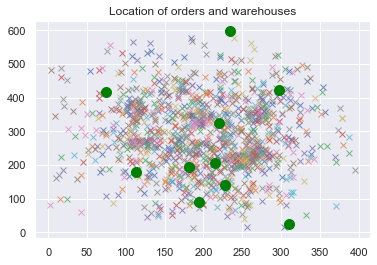

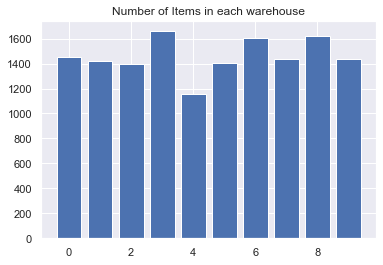

In [3]:
#-- Geograhical plot of warehouses and orders
wrhs_loc = [wrhs_info[i][0] for i in range(len(wrhs_info))]
order_loc = [order_info[i][0] for i in range(len(order_info))]

plt.figure()
plt.title("Location of orders and warehouses")
for i in order_loc:
    plt.plot(i[0], int(i[1]), "-x", alpha = 0.8)
for i in wrhs_loc:
    plt.plot(i[0], int(i[1]), "-o", color = 'green', ms = '10')
plt.show()

#-- Number of items in each warehouse
wrhs_n_items = [sum(i[1]) for i in wrhs_info]
plt.figure()
plt.title("Number of Items in each warehouse")
plt.bar(range(len(wrhs_info)), wrhs_n_items)
plt.show()

## General approach

The main idea of the algorithm is the following:\
1) Each drone finds the nearest warehouse and goes there\
2) Next, the drone finds the nearest order whose products are available at the current warehouse and gets assigned to that order\
3) The drone takes the products available at the warehouse and if it has some spare space ('remainder') it looks for another nearest warehouse with the products needed for the current order. If there's such a warehouse then the drone goes there to pick up the missing products types\
4) The drone delivers the order (the order may be still incomplete) and again looks for the nearest warehouse

## Definition of classes

In [5]:
class Dataframes():

    def __init__(self):
        data = sort_data('/Users/aryan/Desktop/Drone_Delivery/HashCode20/busy_day.in')
        self.grid_row, \
        self.grid_col, \
        self.n_drones, \
        self.max_turns, \
        self.max_payload, \
        self.n_prod_types, \
        self.weight_prod_types, \
        self.n_wrhs, \
        self.wrhs_info, \
        self.n_orders, \
        self.order_info = [data[i] for i in range(11)]

    def get_df_orders(self):
        """ Returns a dataframe with orders location and products needed."""
        x_order_loc = [self.order_info[i][0][0] for i in range(len(self.order_info))]
        y_order_loc = [self.order_info[i][0][1] for i in range(len(self.order_info))]
        n_items_per_order = [self.order_info[i][1][0] for i in range(len(self.order_info))]
        df_orders = pd.DataFrame(list(zip(x_order_loc, y_order_loc, n_items_per_order)),
                                 columns=["X", "Y", "N of Items"])
        return df_orders

    def get_df_wrhs(self):
        """ Returns a dataframe with warehouses location and products available."""
        wrhs_x = [self.wrhs_info[i][0][0] for i in range(len(self.wrhs_info))]
        wrhs_y = [self.wrhs_info[i][0][1] for i in range(len(self.wrhs_info))]
        n_items_per_product_type = [self.wrhs_info[i][1] for i in range(len(self.wrhs_info))]
        df_wrhs = pd.DataFrame(list(zip(wrhs_x, wrhs_y, n_items_per_product_type)),
                               columns=["X", "Y", "Amounts"])
        return df_wrhs

# -- Dataframe for Warehouses
data = Dataframes()
df_wrhs = data.get_df_wrhs()
print("-----------------------Warehouses dataframe---------------------")
print('\n', df_wrhs, '\n')

# -- Dataframe for Orders
df_orders = data.get_df_orders()
print("-----------------------Orders dataframe--------------------------")
print('\n', df_orders)

-----------------------Warehouses dataframe---------------------

      X    Y                                            Amounts
0  113  179  [0, 0, 5, 1, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, ...
1  234  599  [0, 0, 3, 1, 1, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, ...
2  195   89  [0, 0, 1, 3, 0, 0, 0, 36, 4, 1, 2, 0, 0, 0, 0,...
3  215  207  [1, 0, 4, 0, 1, 0, 15, 0, 2, 0, 4, 0, 0, 10, 0...
4  220  326  [1, 0, 6, 1, 2, 0, 0, 0, 2, 1, 6, 13, 0, 0, 0,...
5  182  193  [0, 16, 3, 0, 1, 0, 0, 0, 5, 0, 3, 0, 0, 0, 0,...
6   75  418  [1, 0, 6, 0, 1, 0, 0, 0, 10, 0, 3, 0, 0, 0, 0,...
7  228  140  [0, 0, 6, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, ...
8  310   26  [1, 0, 8, 1, 0, 33, 0, 0, 1, 1, 6, 0, 0, 0, 0,...
9  297  423  [1, 0, 4, 2, 0, 0, 0, 0, 6, 0, 9, 0, 23, 0, 40... 

-----------------------Orders dataframe--------------------------

         X    Y  N of Items
0     340  371           8
1     163  320           1
2     201  331           2
3     257  290          10
4     115  512           8
...   ..

In [6]:
def dist(a, b):
    """Calculates distance between two or more objects."""
    if isinstance(a, np.ndarray) or isinstance(b, np.ndarray):
        return np.sqrt(((a - b) ** 2).sum(1))
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def num_turns(self, dist):
    """Calculate number of turns required to cover a certain distance."""
    return math.ceil(dist)

In [7]:
class Drone():

    def __init__(self, num, weight_prod_types):
        self.num = num # number of the drone
        self.pld_weight = 0 # current drone payload
        self.cur_pos = [0, 0] # current position of a drone
        self.turns = 0 # initializing number of turns to zero
        self.actions = []  # list of drone actions 
        self.state = 'W' # initialize drone state to 'wait'
        self.weights = np.array(weight_prod_types) 
        self.orders = [] # list of orders that a drone is working on 
        self.amounts = np.zeros(400)
        self.types = np.arange(400)
        self.remainder = 0 # spare payload of a drone after loading products 

    def __repr__(self):
        return '(num: ' + str(self.num) + ', ' + 'types: ' + str(self.types[self.amounts>0]) + ', ' + 'amounts: ' +  str(self.amounts[self.amounts>0]) + ')'
    
    def compute_weight(self):
        """Returns total weight of all items carried by the drone at the moment."""
        return self.weights[self.types]*self.amounts[self.types]

    def load(self, prod_types, prod_qnty, wrhs):
        """Loads products into a drone."""
        self.state = 'L' 
        self.amounts[prod_types] += 1
        self.compute_weight()
        message = []
        for i in range(prod_types.shape[0]):
            message.append(f'{self.num} {self.state} {wrhs.num} {prod_qnty[i]} {prod_types[i]}')
        self.turns += prod_types.shape[0] 
        return message

    def unload(self, prod_types, qnty):
        self.turns += 1

    def deliver(self, prod_types, prod_qnty, order, orders):
        """Delivers products to the order (unloading process)."""
        self.state = 'D'
        message = []
        for i in range(prod_types.shape[0]):
            message.append(f'{self.num} {self.state} {order.num} {prod_qnty[i]} {prod_types[i]}')
        self.turns += prod_types.shape[0]
        self.amounts[prod_types] -= prod_qnty
        self.compute_weight()
        return message 

    def wait(self, n_turns):
        """Drone waits for n turns."""
        self.state = 'W'
        self.turns += n_turns

    def get_cur_pos(self):
        """Returns current position of a drone."""
        return self.cur_pos

    def update_cur_pos(self, new_pos):
        self.cur_pos = new_pos 

    def find_nearest_wh(self, warehouses):
        """Returns the nearest warehouse."""
        wh = np.array(warehouses.positions, dtype=np.float64)
        wh[(warehouses.check_empty())|warehouses.not_avail] = np.inf
        d = dist(self.cur_pos, wh)
        return warehouses.dict[np.argmin(d)]

    def check_pld_weight(self):
        """Checks if the drone is full."""
        return self.pld_weight <= 200

    def select_avail_types(self, wrhs, order):
        """Returns order product types which are available at the warehouse."""
        avail_types = order.prod_types[order.check_avail_types(wrhs)]
        return avail_types

    def select_avail_quantities(self, avail_types, order, wrhs):
        """Returns the minimum quantity between that available in the warehouse and the one required in order."""
        wrhs_qnty = wrhs.amounts[avail_types] 
        order_qnty = order.amounts[avail_types]
        selected_qnty = np.column_stack((wrhs_qnty, order_qnty)).min(1)
        assert np.all(selected_qnty == np.min((wrhs_qnty, order_qnty), 0))
        return selected_qnty

    def find_nearest_order(self, orders, warehouses, wrhs):  # dictionary of orders (class Orders)
        """Finds the nearest order to the warehouse. """
        if self.orders != []:
            last_order = self.orders[-1]
            if last_order.amount>0 and np.any(last_order.check_avail_types(wrhs)):
                return self.orders[-1], 'last' #54229
        order_pos = orders.positions.astype(np.float64)
        c = orders.completed
        check_avail = warehouses.all_avail_orders[wrhs.num]
        
        if c.sum() == 1250:
            return 'All orders are completed', 'completed'
        order_pos[(c)|(~check_avail)] = np.inf
        d = dist(self.cur_pos, order_pos)
        
        if np.min(d) == np.inf:
            order_pos = orders.positions.astype(np.float64)
            check_avail = warehouses.any_avail_orders[wrhs.num]
            order_pos[(c)|(~check_avail)] = np.inf
            d = dist(self.cur_pos, order_pos)
            if np.min(d) == np.inf:
                assert order_pos.min() == np.inf
                wrhs.update_not_avail(warehouses)
            nearest_order = orders.dict[np.argmin(d)]
            return nearest_order, 0
        nearest_order = orders.dict[np.argmin(d)]
        return nearest_order, 1

    def assign_order(self, order, wrhs, warehouses):
        """Assigns an order to the drone: loads the products into the drone 
           and removes them from the warehouse."""
        self.orders.append(order)
        avail_types = self.select_avail_types(wrhs, order)
        avail_qnty = self.select_avail_quantities(avail_types, order, wrhs)
        
        if np.sum(self.weights[avail_types]*avail_qnty) <= 200:
            # if total weight of the order is below 200, the drone takes all the products needed
            new_types = avail_types
            new_qnty = avail_qnty
        else:
            # else, the products are sorted in descending order by weight and the drone picks 
            # the items until the weight exceeds 200. The remainder space is counted. 
            types = np.repeat(avail_types, avail_qnty)
            weights = self.weights[types]
            repeated_matrix = np.column_stack((types, weights))
            rep_mat_sorted = repeated_matrix[repeated_matrix[:,1].argsort()]
            new_sorted_matrix = rep_mat_sorted[::-1]
            mask_le200 = new_sorted_matrix[:,1].cumsum() <= 200
            new_types_repeated = new_sorted_matrix[mask_le200][:,0]
            new_types, new_qnty = np.unique(new_types_repeated, return_counts=True)
            new_weigths_repeated = self.weights[new_types_repeated]
            remainder = 200 - new_weigths_repeated.sum()
            self.remainder = remainder
            
        wrhs.remove_product(new_types, new_qnty, warehouses)
        loading_message = self.load(new_types, new_qnty, wrhs)
        return new_types, new_qnty, loading_message

    def deliver_order(self, types, qnty, order, orders):
        """Delivers the products to the order and checks if the order was completed."""
        self.turns += np.int(np.ceil(dist(self.cur_pos, order.position)))
        self.update_cur_pos(order.position)
        delivery_message = self.deliver(types, qnty, order, orders)
        order.remove_prod(types, qnty)
        assert order.amount >= 0
        self.remainder = 0
        self.compute_weight()
        order.check_completed(self.turns, orders)
        return delivery_message

    def find_nearest_wh_with_types(self, warehouses, leftover_types):
        """Returns the nearest warehouse with the products needed."""
        leftover_acceptable_types = leftover_types[self.weights[leftover_types]<=self.remainder]
        avail_acceptable_leftover = np.array([np.any(x[leftover_acceptable_types]) for x in warehouses.avail_products])
        wh = np.array(warehouses.positions, dtype=np.float64)
        wh[~avail_acceptable_leftover] = np.inf
        d = dist(self.cur_pos, wh)
    
        if d.min() == np.inf:
            return 'no_pickup', []
        index_argmin = np.argmin(d)
        wh_next_pickup = warehouses.dict[index_argmin]
        types_in_remainder = leftover_types[wh_next_pickup.avail_products[leftover_types]]
        types_sorted = types_in_remainder[self.weights[types_in_remainder].argsort()]
        types_chosen = types_sorted[self.weights[types_sorted].cumsum()<=self.remainder]
        return wh_next_pickup, types_chosen  

    def assign_pickup(self, wh_next_pickup, types_in_remainder, warehouses):
        """Picks the remaining products of the order from another warehouse."""
        qnty_remainder = np.ones(len(types_in_remainder), dtype=np.int64)
        wh_next_pickup.remove_product(types_in_remainder, qnty_remainder, warehouses)
        loading_message = self.load(types_in_remainder, qnty_remainder, wh_next_pickup)
        assert self.compute_weight().sum() <= 200
        self.remainder -= self.weights[types_in_remainder].sum()
        return types_in_remainder, qnty_remainder, loading_message

In [8]:
class Order():

    def __init__(self, num, x, y, amount, types, weight_prod_types):
        self.amount = amount[0]
        self.num = num
        self.position = (x, y)
        self.completed = False
        self.turn_order_completed = 0
        self.all_weights = weight_prod_types
        self.typelist = np.array(types)
        self.amounts = np.zeros(400, dtype=np.int32) 
        self.types = np.arange(400, dtype=np.int32)
        t, a = np.unique(self.typelist, return_counts=True)
        self.amounts[t] += a
        self.weights = np.array(weight_prod_types)
        self.prod_amounts = self.amounts[self.amounts>0]
        self.prod_types = self.types[self.amounts>0]
        self.tot_weight = np.sum(self.weights*self.amounts)
        self.assigned = 0

    def __repr__(self):
        return '(num: ' + str(self.num) + ', ' + 'n_items: ' + str(
            self.amount) + ', ' + 'tot_weight: ' + str(
                self.tot_weight) + ', ' + 'types: ' + str(self.prod_types) + ', ' + 'quantities: ' + str(
                    self.prod_amounts) + ', ' + 'weights:' + str(self.weights[self.amounts>0]) + ')'

    def remove_prod(self, prod_type, prod_qnty):
        """Removes a product from an order once it is delivered."""
        self.amounts[prod_type] -= prod_qnty
        self.prod_amounts = self.amounts[self.amounts>0]
        self.prod_types = self.types[self.amounts>0]
        t = list(self.typelist)
        for x in list(np.repeat(prod_type, prod_qnty)):
            t.remove(x)
        self.typelist = np.array(t)
        self.amount -= prod_qnty.sum()
        self.tot_weight = np.sum(self.weights[self.prod_types]*self.amounts[self.prod_types])
        
    def check_completed(self, turn, orders):
        """Checks if the order is completed and saves the turn in which it was completed."""
        if self.amounts.sum() == 0:
            self.completed = True
            self.turn_order_completed = turn
            orders.add_completed(self.num)
            orders.turn_order_completed[self.num] = self.turn_order_completed

    def check_avail_types(self, wrhs):
        """"Returns a boolean list for product types available at the warehouse."""
        avail = wrhs.avail_products[self.prod_types]
        return avail

class Orders():
    """Auxiliary class for orders which stores positions and states of all the orders."""
    def __init__(self, n_orders, ordersdict):
        positions = [ordersdict[x].position for x in ordersdict]
        self.positions = np.array(positions)
        self.n_orders = n_orders
        self.dict = ordersdict
        completed = [ordersdict[x].completed for x in ordersdict]
        self.completed = np.array(completed)
        self.turn_order_completed = [ordersdict[x].turn_order_completed for x in ordersdict]

    def __repr__(self):
        return f'n_orders: {self.n_orders}, completed: {self.completed.sum()}'

    def add_completed(self, ordernum):
        self.completed[ordernum] = True

In [9]:
class Product():

    def __init__(self, type, weight):
        self.type = type
        self.weight = weight

In [10]:
class Warehouse():

    def __init__(self, num, x, y, amounts, weight_product_types):
        # amounts - list of every product type amount, some are zero if that product type is not available
        # weight_product_types - weights of product types in this warehouse
        self.num = num
        self.position = (x, y) 
        self.amounts = np.array(amounts)
        self.types = np.arange(400)
        self.avail_products = (self.amounts>0)
        self.tot_amounts = self.amounts.sum()
        self.not_avail = False
        
    def __repr__(self):
        return '(num: ' + str(self.num) + ', ' + 'position: ' + str(self.position) + ', ' + 'tot_amount: ' + str(self.tot_amounts) + ')'

    def add_product(self, prod_type, prod_qnty):
        """Adds products to the warehouse."""
        self.prod_amounts.append(prod_qnty)

    def remove_product(self, prod_type, prod_qnty, warehouses):
        """Removes a certain quantity of a product type from a warehouse."""
        self.amounts[prod_type] -= prod_qnty
        self.avail_products = (self.amounts>0) 
        warehouses.tot_amounts[self.num] = self.amounts.sum()
        warehouses.avail_products[self.num] =  self.avail_products
        assert np.all(self.amounts>=0)
    
    def update_not_avail(self, warehouses):
        self.not_avail = True
        warehouses.not_avail[self.num] = True

    # only update the true ones
    def update_availability(self,  warehouses, orders):
        """For each warehouse updates the list of orders with all/any products available
           at the warehouse."""
        not_completed_orders = np.flatnonzero(~orders.completed)
        warehouses.all_avail_orders[self.num][orders.completed] = False
        warehouses.any_avail_orders[self.num][orders.completed] = False
        avail_orders_any = np.flatnonzero(warehouses.any_avail_orders[self.num])
        warehouses.all_avail_orders[self.num][not_completed_orders] = np.array([np.all(orders.dict[o].check_avail_types(self)) 
        for o in not_completed_orders]) 
        warehouses.any_avail_orders[self.num][avail_orders_any] = np.array([np.any(orders.dict[o].check_avail_types(self)) 
        for o in avail_orders_any]) 
                
class Warehouses():
    """Auxiliary class for warehouses which stores positions of all the warehouses. 
       For each warehouse a dictionary of orders which have all products available at 
       that warehouse and another dictionary of orders which have any of their products available at the warehouse."""
    def __init__(self, n_wrhs, orders, wrhsdict):
        self.n_wrhs = n_wrhs
        self.dict = wrhsdict
        positions = [wrhsdict[x].position for x in wrhsdict]
        self.tot_amounts = [wrhsdict[x].amounts.sum() for x in wrhsdict]
        self.positions = positions
        self.avail_products = [wrhsdict[x].avail_products for x in wrhsdict]
        self.not_avail = np.array([(wrhsdict[x].not_avail) for x in wrhsdict])
        self.all_avail_orders = {}
        for w in self.dict.values():
            self.all_avail_orders[w.num] = np.array([np.all(
                o.check_avail_types(w)) for o in orders.dict.values()])
        self.any_avail_orders = {}
        for w in self.dict.values():
            self.any_avail_orders[w.num] = np.array([np.any(
                o.check_avail_types(w)) for o in orders.dict.values()])

    def check_empty(self):
        empty_warehouses = [self.dict[x].amounts.sum() <= 0 for x in self.dict]
        return np.array(empty_warehouses)


## Simulation

In [11]:
# DRONES
drones = [Drone(i, weight_prod_types) for i in range(n_drones)]
dronesdict = dict(enumerate(drones))

# ORDERS
# n_orders =100
orderslist = [Order(i, order_info[i][0][0], order_info[i][0][1], order_info[i][1], order_info[i][2], weight_prod_types) for
          i in range(n_orders)]
ordersdict = dict(enumerate(orderslist))
orders = Orders(n_orders, ordersdict)

# WAREHOUSES
wrhslist = [Warehouse(i, wrhs_info[i][0][0], wrhs_info[i][0][1], wrhs_info[i][1], weight_prod_types) for i in
        range(n_wrhs)]
wrhsdict = dict(enumerate(wrhslist))
warehouses = Warehouses(n_wrhs, orders, wrhsdict)

# Drones must start a wharehouse 0
# then move 3 drones to each warehouse
for i in dronesdict:
    dronesdict[i].update_cur_pos(wrhsdict[0].position)
    dronesdict[i].turns += np.int(np.ceil(dist(dronesdict[i].cur_pos, wrhsdict[i % 10].position)))
    dronesdict[i].update_cur_pos(wrhsdict[i%10].position)

# do one cycle of sim:
completed = 0
message = 0
no_type = 0
remainder = 0
total_message = []

while completed<1251:
    for k in dronesdict:

        drone = dronesdict[k]
        nearest_warehouse = drone.find_nearest_wh(warehouses)
        drone.turns += np.int(np.ceil(dist(drone.cur_pos, nearest_warehouse.position)))
        drone.update_cur_pos(nearest_warehouse.position)
            
        nearest_warehouse.update_availability(warehouses, orders)
        nearest_order, all = drone.find_nearest_order(orders, warehouses, nearest_warehouse)
        if nearest_order == 'All orders are completed':
            message = 'DONE'
            break
        types, qnty, loading_message = drone.assign_order(nearest_order, nearest_warehouse, warehouses)
        nearest_warehouse.update_availability(warehouses, orders)
        print(types, drone.weights[types])
    #####
        if drone.remainder != 0:
            leftover_types = nearest_order.typelist[~np.isin(nearest_order.typelist, types)] 
            if ((len(leftover_types > 0)) and (np.any(drone.weights[leftover_types] <= drone.remainder))):
                print(nearest_order)
                wh_next_pickup, types_in_remainder = drone.find_nearest_wh_with_types(warehouses, leftover_types)
                wh_next_pickup.update_availability(warehouses, orders)
                if len(types_in_remainder) > 0:
                    types_in_remainder, qnty_remainder, loading_message_r = drone.assign_pickup(wh_next_pickup,
                                                                                                types_in_remainder,
                                                                                                warehouses)
                    drone.turns += np.int(np.ceil(dist(drone.cur_pos, wh_next_pickup.position)))

                    # update quantitites and types
                    old_stack = np.column_stack((types, qnty))
                    new_stack = np.column_stack((types_in_remainder, qnty_remainder))
                    tot_stack = np.vstack((old_stack, new_stack))
                    types, qnty = np.unique(tot_stack[:, 0], return_counts=True)
                    loading_message = loading_message + loading_message_r
                    remainder += 1
                    #reset remainder done in assing_order
        
        if types.shape[0]>0:
        # check availability of each product type order in warehouse
            delivery_message = drone.deliver_order(types, qnty, nearest_order, orders)
            print(f'drone: {drone.num}', f'wrhs: {nearest_warehouse.num}',f'all: {all}',
            f'tot_items: {warehouses.tot_amounts}', f'completed: {orders.completed.sum()}',
                     f'items moved: {qnty.sum()}', f'remainder: {remainder}', sep = ',')
            total_message.append(loading_message + delivery_message)
        else: 
            print('no_type')
            no_type += 1
            drone.update_cur_pos(nearest_order.position)
            drone.turns += np.int(np.ceil(dist(drone.cur_pos, nearest_order.position)))

        completed = orders.completed.sum()
    if message == 'DONE':
        print(f'orders: {orders.dict}')
        print(f'warehouses: {warehouses.dict}')
        print(f'drones: {drones}')
        print(f'message: {total_message}')
        max_turns_drones = np.max(np.array([x.turns for x in drones]))
        print(f'max number of turns: {max_turns_drones}') 
        print(f'number of cycles with 0 products delivered: {no_type}')
        turns_orders_completed = np.array(orders.turn_order_completed)
        score = np.sum(np.ceil((max_turns_drones-turns_orders_completed)/max_turns_drones*100))
        print(f'score: {score}')
        break



[ 35 122 179 216] [36 35 26 32]
drone: 0,wrhs: 0,all: 1,tot_items: [1446, 1423, 1394, 1659, 1155, 1403, 1602, 1437, 1619, 1434],completed: 1,items moved: 4,remainder: 0
[ 83 175] [ 38 132]
drone: 1,wrhs: 1,all: 1,tot_items: [1446, 1421, 1394, 1659, 1155, 1403, 1602, 1437, 1619, 1434],completed: 2,items moved: 2,remainder: 0
[205] [95]
drone: 2,wrhs: 2,all: 1,tot_items: [1446, 1421, 1393, 1659, 1155, 1403, 1602, 1437, 1619, 1434],completed: 3,items moved: 1,remainder: 0
[ 83 154 210] [38 92 52]
drone: 3,wrhs: 3,all: 1,tot_items: [1446, 1421, 1393, 1656, 1155, 1403, 1602, 1437, 1619, 1434],completed: 4,items moved: 3,remainder: 0
[ 10 149 287] [93 21 40]
drone: 4,wrhs: 4,all: 1,tot_items: [1446, 1421, 1393, 1656, 1152, 1403, 1602, 1437, 1619, 1434],completed: 5,items moved: 3,remainder: 0
[225] [108]
drone: 5,wrhs: 5,all: 1,tot_items: [1446, 1421, 1393, 1656, 1152, 1402, 1602, 1437, 1619, 1434],completed: 6,items moved: 1,remainder: 0
[290 375] [40 44]
drone: 6,wrhs: 6,all: 1,tot_items: 

[237 388] [ 52 138]
drone: 22,wrhs: 2,all: 1,tot_items: [1436, 1413, 1383, 1647, 1146, 1392, 1592, 1428, 1605, 1424],completed: 39,items moved: 2,remainder: 5
[151 270] [97 95]
drone: 23,wrhs: 3,all: 1,tot_items: [1436, 1413, 1383, 1645, 1146, 1392, 1592, 1428, 1605, 1424],completed: 39,items moved: 2,remainder: 5
[288] [62]
drone: 24,wrhs: 4,all: 1,tot_items: [1436, 1413, 1383, 1645, 1145, 1392, 1592, 1428, 1605, 1424],completed: 40,items moved: 1,remainder: 5
[181 233 398] [69 37 52]
drone: 25,wrhs: 3,all: 1,tot_items: [1436, 1413, 1383, 1642, 1145, 1392, 1592, 1428, 1605, 1424],completed: 41,items moved: 3,remainder: 5
[191] [43]
drone: 26,wrhs: 6,all: 1,tot_items: [1436, 1413, 1383, 1642, 1145, 1392, 1591, 1428, 1605, 1424],completed: 42,items moved: 1,remainder: 5
[259] [11]
drone: 27,wrhs: 7,all: 1,tot_items: [1436, 1413, 1383, 1642, 1145, 1392, 1591, 1427, 1605, 1424],completed: 43,items moved: 1,remainder: 5
[ 41 119] [67 68]
drone: 28,wrhs: 8,all: 1,tot_items: [1436, 1413, 138

[136 153 192] [75 43 51]
drone: 10,wrhs: 3,all: 1,tot_items: [1436, 1413, 1374, 1625, 1136, 1382, 1581, 1414, 1603, 1415],completed: 74,items moved: 3,remainder: 11
[241] [46]
drone: 11,wrhs: 6,all: 1,tot_items: [1436, 1413, 1374, 1625, 1136, 1382, 1580, 1414, 1603, 1415],completed: 75,items moved: 1,remainder: 11
[ 46 137] [91 28]
drone: 12,wrhs: 2,all: 1,tot_items: [1436, 1413, 1372, 1625, 1136, 1382, 1580, 1414, 1603, 1415],completed: 76,items moved: 2,remainder: 11
[17 96] [49 39]
drone: 13,wrhs: 3,all: 1,tot_items: [1436, 1413, 1372, 1623, 1136, 1382, 1580, 1414, 1603, 1415],completed: 77,items moved: 2,remainder: 11
[ 52 149 210 243] [40 21 52 52]
drone: 14,wrhs: 4,all: 1,tot_items: [1436, 1413, 1372, 1623, 1132, 1382, 1580, 1414, 1603, 1415],completed: 78,items moved: 4,remainder: 11
[  2 154] [84 92]
drone: 15,wrhs: 3,all: 1,tot_items: [1436, 1413, 1372, 1621, 1132, 1382, 1580, 1414, 1603, 1415],completed: 79,items moved: 2,remainder: 11
[ 26 126] [40 21]
drone: 16,wrhs: 4,all:

[192] [51]
drone: 29,wrhs: 4,all: last,tot_items: [1436, 1413, 1368, 1590, 1107, 1382, 1572, 1398, 1601, 1413],completed: 111,items moved: 1,remainder: 15
[372] [41]
drone: 0,wrhs: 3,all: 1,tot_items: [1436, 1413, 1368, 1589, 1107, 1382, 1572, 1398, 1601, 1413],completed: 112,items moved: 1,remainder: 15
[ 78 213] [45 74]
drone: 1,wrhs: 4,all: 1,tot_items: [1436, 1413, 1368, 1589, 1105, 1382, 1572, 1398, 1601, 1413],completed: 113,items moved: 2,remainder: 15
[ 15 121] [93 61]
drone: 2,wrhs: 3,all: 1,tot_items: [1436, 1413, 1368, 1587, 1105, 1382, 1572, 1398, 1601, 1413],completed: 114,items moved: 2,remainder: 15
[ 40 155] [ 65 109]
drone: 3,wrhs: 4,all: 1,tot_items: [1436, 1413, 1368, 1587, 1103, 1382, 1572, 1398, 1601, 1413],completed: 114,items moved: 2,remainder: 15
[287] [40]
drone: 4,wrhs: 4,all: 1,tot_items: [1436, 1413, 1368, 1587, 1102, 1382, 1572, 1398, 1601, 1413],completed: 115,items moved: 1,remainder: 15
[117 120 162 208 216] [37 52 13 38 32]
drone: 5,wrhs: 4,all: 1,tot_

[172 398] [45 52]
drone: 18,wrhs: 4,all: 1,tot_items: [1410, 1413, 1368, 1564, 1064, 1376, 1563, 1396, 1601, 1411],completed: 144,items moved: 2,remainder: 24
[ 51 270] [77 95]
drone: 19,wrhs: 6,all: 1,tot_items: [1410, 1413, 1368, 1564, 1064, 1376, 1561, 1396, 1601, 1411],completed: 144,items moved: 2,remainder: 24
[111 133 243] [63 70 52]
drone: 20,wrhs: 0,all: 1,tot_items: [1407, 1413, 1368, 1564, 1064, 1376, 1561, 1396, 1601, 1411],completed: 144,items moved: 3,remainder: 24
[ 77 126 210 296] [27 21 52 36]
drone: 21,wrhs: 0,all: 1,tot_items: [1403, 1413, 1368, 1564, 1064, 1376, 1561, 1396, 1601, 1411],completed: 145,items moved: 4,remainder: 24
[292] [105]
drone: 22,wrhs: 7,all: last,tot_items: [1403, 1413, 1368, 1564, 1064, 1376, 1561, 1395, 1601, 1411],completed: 145,items moved: 1,remainder: 24
[317] [34]
drone: 23,wrhs: 4,all: 1,tot_items: [1403, 1413, 1368, 1564, 1063, 1376, 1561, 1395, 1601, 1411],completed: 146,items moved: 1,remainder: 24
[393] [132]
(num: 512, n_items: 9, 

[ 46 239] [ 91 101]
drone: 0,wrhs: 4,all: 0,tot_items: [1385, 1413, 1365, 1550, 1037, 1375, 1551, 1389, 1601, 1411],completed: 158,items moved: 2,remainder: 35
[384] [27]
drone: 1,wrhs: 2,all: 1,tot_items: [1385, 1413, 1364, 1550, 1037, 1375, 1551, 1389, 1601, 1411],completed: 159,items moved: 1,remainder: 35
[49] [128]
(num: 131, n_items: 3, tot_weight: 256, types: [ 49 222 328], quantities: [1 1 1], weights:[128 107  21])
drone: 2,wrhs: 2,all: 1,tot_items: [1385, 1413, 1362, 1550, 1037, 1375, 1551, 1389, 1601, 1411],completed: 159,items moved: 2,remainder: 36
[222] [107]
drone: 3,wrhs: 2,all: 1,tot_items: [1385, 1413, 1361, 1550, 1037, 1375, 1551, 1389, 1601, 1411],completed: 160,items moved: 1,remainder: 36
[201 283] [57 25]
drone: 4,wrhs: 4,all: 0,tot_items: [1385, 1413, 1361, 1550, 1035, 1375, 1551, 1389, 1601, 1411],completed: 160,items moved: 2,remainder: 36
[  8  95 181 287] [36 52 69 40]
drone: 5,wrhs: 4,all: 0,tot_items: [1385, 1413, 1361, 1550, 1031, 1375, 1551, 1389, 1601, 

[104 313 360] [49 33 24]
drone: 13,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1540, 985, 1374, 1542, 1389, 1601, 1401],completed: 172,items moved: 3,remainder: 44
[ 64 262] [105  74]
(num: 966, n_items: 10, tot_weight: 600, types: [ 41  44  64  92 138 189 256 259 262 395], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[ 67  23 105  51  25  43  87  11  74 114])
drone: 14,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1540, 982, 1374, 1542, 1389, 1601, 1401],completed: 172,items moved: 3,remainder: 45
[138 189] [25 43]
drone: 15,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1540, 980, 1374, 1542, 1389, 1601, 1401],completed: 172,items moved: 2,remainder: 45
[75] [141]
drone: 16,wrhs: 6,all: 1,tot_items: [1374, 1413, 1361, 1540, 980, 1374, 1541, 1389, 1601, 1401],completed: 172,items moved: 1,remainder: 45
[204 270] [72 95]
(num: 798, n_items: 5, tot_weight: 251, types: [129 168 204 270 299], quantities: [1 1 1 1 1], weights:[40 36 72 95  8])
drone: 17,wrhs: 4,all: 0,tot_items: [1374, 1413, 1

[299] [8]
drone: 23,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1532, 913, 1374, 1540, 1389, 1601, 1392],completed: 177,items moved: 1,remainder: 56
[111 304] [63 24]
drone: 24,wrhs: 9,all: 1,tot_items: [1374, 1413, 1361, 1532, 913, 1374, 1540, 1389, 1601, 1390],completed: 178,items moved: 2,remainder: 56
[ 10 390] [93 97]
drone: 25,wrhs: 9,all: 1,tot_items: [1374, 1413, 1361, 1532, 913, 1374, 1540, 1389, 1601, 1388],completed: 178,items moved: 2,remainder: 56
[104 119 375] [49 68 44]
drone: 26,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1532, 910, 1374, 1540, 1389, 1601, 1388],completed: 178,items moved: 3,remainder: 56
[175 201] [132  57]
drone: 27,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1532, 908, 1374, 1540, 1389, 1601, 1388],completed: 178,items moved: 2,remainder: 56
[144 268 397 398] [52 32 41 52]
drone: 28,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1532, 904, 1374, 1540, 1389, 1601, 1388],completed: 178,items moved: 4,remainder: 56
[360] [24]
drone: 29,wrhs: 4,all: 0,t

[85] [117]
(num: 797, n_items: 12, tot_weight: 825, types: [ 37  66  85 120 130 149 237 282 300 371 379 390], quantities: [1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 74 105 117  52 105  21  52 100  23  45  34  97])
drone: 9,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1530, 824, 1374, 1536, 1389, 1601, 1388],completed: 180,items moved: 3,remainder: 66
[237 390] [52 97]
(num: 797, n_items: 9, tot_weight: 664, types: [ 37  66 120 130 237 282 371 379 390], quantities: [1 1 1 1 1 1 1 1 1], weights:[ 74 105  52 105  52 100  45  34  97])
drone: 10,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1530, 821, 1374, 1536, 1389, 1601, 1388],completed: 180,items moved: 3,remainder: 67
[120] [52]
drone: 11,wrhs: 4,all: 0,tot_items: [1374, 1413, 1361, 1530, 820, 1374, 1536, 1389, 1601, 1388],completed: 180,items moved: 1,remainder: 67
[111 225] [ 63 108]
(num: 850, n_items: 10, tot_weight: 578, types: [ 12  45 104 111 172 216 225 340 364 397], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[123  26  49  63  45  32

drone: 19,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1529, 738, 1374, 1530, 1389, 1601, 1388],completed: 181,items moved: 3,remainder: 78
[ 78 216] [45 32]
drone: 20,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1529, 736, 1374, 1530, 1389, 1601, 1388],completed: 181,items moved: 2,remainder: 78
[114 253 299] [31 29  8]
drone: 21,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1529, 733, 1374, 1530, 1389, 1601, 1388],completed: 181,items moved: 3,remainder: 78
[164 229] [93 71]
(num: 909, n_items: 9, tot_weight: 535, types: [  6 164 169 195 229 253 272 370 371], quantities: [1 1 1 1 1 1 1 1 1], weights:[ 13  93  55 110  71  29  43  76  45])
drone: 22,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1529, 730, 1374, 1530, 1389, 1601, 1388],completed: 181,items moved: 3,remainder: 79
[169] [55]
drone: 23,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1529, 729, 1374, 1530, 1389, 1601, 1388],completed: 181,items moved: 1,remainder: 79
[48] [142]
(num: 848, n_items: 8, tot_weight: 711, types: [ 48

[141 275] [72 78]
drone: 29,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1521, 671, 1374, 1530, 1389, 1601, 1381],completed: 185,items moved: 2,remainder: 90
[ 50 278] [ 9 27]
drone: 0,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1521, 669, 1374, 1530, 1389, 1601, 1381],completed: 185,items moved: 2,remainder: 90
[  4  35 164] [52 36 93]
drone: 1,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1521, 666, 1374, 1530, 1389, 1601, 1381],completed: 185,items moved: 3,remainder: 90
[  2 223] [84 82]
(num: 385, n_items: 12, tot_weight: 713, types: [  2   5  54  83  97 218 223 276 279 364 365 388], quantities: [1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 84  36  55  38  54  39  82  25  90  16  56 138])
drone: 2,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1521, 664, 1373, 1530, 1389, 1601, 1381],completed: 185,items moved: 3,remainder: 91
[ 83 218] [38 39]
drone: 3,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1521, 662, 1373, 1530, 1389, 1601, 1381],completed: 185,items moved: 2,remainder: 91
[ 76 216 3

[150] [110]
drone: 16,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1517, 586, 1373, 1530, 1389, 1601, 1380],completed: 186,items moved: 1,remainder: 98
[225 243] [108  52]
drone: 17,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1517, 584, 1373, 1530, 1389, 1601, 1380],completed: 186,items moved: 2,remainder: 98
[167] [104]
(num: 263, n_items: 5, tot_weight: 389, types: [167 206 241 242 244], quantities: [1 1 1 1 1], weights:[104  76  46 100  63])
drone: 18,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1516, 583, 1373, 1530, 1389, 1601, 1380],completed: 186,items moved: 2,remainder: 99
[242] [100]
drone: 19,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1516, 582, 1373, 1530, 1389, 1601, 1380],completed: 186,items moved: 1,remainder: 99
[100 221] [127  68]
drone: 20,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1516, 580, 1373, 1530, 1389, 1601, 1380],completed: 186,items moved: 2,remainder: 99
[ 26 227 350] [40 38 74]
drone: 21,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1516, 577, 1373, 1

[ 45 252 285] [26 13 80]
drone: 0,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1505, 517, 1372, 1530, 1389, 1601, 1379],completed: 186,items moved: 3,remainder: 108
[181 242] [ 69 100]
(num: 531, n_items: 8, tot_weight: 457, types: [ 16 157 181 242 283 299 375 399], quantities: [1 1 1 1 1 1 1 1], weights:[ 62  89  69 100  25   8  44  60])
drone: 1,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1504, 515, 1372, 1530, 1389, 1601, 1379],completed: 186,items moved: 3,remainder: 109
[ 16 375] [62 44]
drone: 2,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1504, 513, 1372, 1530, 1389, 1601, 1379],completed: 186,items moved: 2,remainder: 109
[100 297] [127  46]
(num: 289, n_items: 16, tot_weight: 1172, types: [ 15  18  63 100 133 212 235 239 268 296 297 312 362 395 399], quantities: [2 1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 93  97  11 127  70  58  51 101  32  36  46  62 121 114  60])
drone: 3,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1504, 510, 1372, 1530, 1389, 1601, 1379],completed: 186,ite

[127] [144]
drone: 14,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1488, 445, 1372, 1530, 1389, 1601, 1379],completed: 186,items moved: 1,remainder: 118
[149 162 191] [21 13 43]
drone: 15,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1488, 442, 1372, 1530, 1389, 1601, 1379],completed: 186,items moved: 3,remainder: 118
[226 290] [57 40]
drone: 16,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1488, 440, 1372, 1530, 1389, 1601, 1379],completed: 186,items moved: 2,remainder: 118
[ 96 301] [39 58]
drone: 17,wrhs: 3,all: last,tot_items: [1374, 1413, 1360, 1486, 440, 1372, 1530, 1389, 1601, 1379],completed: 186,items moved: 2,remainder: 118
[377] [136]
(num: 1125, n_items: 12, tot_weight: 712, types: [ 51  76  80  96 105 128 129 190 257 282 364 377], quantities: [1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 77  54  21  39  40  21  40  82  86 100  16 136])
drone: 18,wrhs: 3,all: last,tot_items: [1374, 1413, 1360, 1483, 440, 1372, 1530, 1389, 1601, 1379],completed: 186,items moved: 3,remainder: 119
[190 2

[191 245] [43 36]
drone: 28,wrhs: 3,all: 0,tot_items: [1374, 1413, 1360, 1450, 411, 1371, 1530, 1389, 1601, 1368],completed: 186,items moved: 2,remainder: 127
[122 138 299 382] [35 25  8 64]
drone: 29,wrhs: 9,all: last,tot_items: [1374, 1413, 1360, 1450, 411, 1371, 1530, 1389, 1601, 1364],completed: 186,items moved: 4,remainder: 127
[225 229] [108  71]
drone: 0,wrhs: 3,all: 0,tot_items: [1374, 1413, 1360, 1448, 411, 1371, 1530, 1389, 1601, 1364],completed: 186,items moved: 2,remainder: 127
[186 275] [84 78]
(num: 905, n_items: 8, tot_weight: 455, types: [ 71  97 168 186 275 284 348 364], quantities: [1 1 1 1 1 1 1 1], weights:[40 54 36 84 78 72 75 16])
drone: 1,wrhs: 9,all: last,tot_items: [1374, 1413, 1360, 1448, 411, 1370, 1530, 1389, 1601, 1362],completed: 186,items moved: 3,remainder: 128
[186 299] [84  8]
drone: 2,wrhs: 3,all: last,tot_items: [1374, 1413, 1360, 1446, 411, 1370, 1530, 1389, 1601, 1362],completed: 186,items moved: 2,remainder: 128
[ 35 194] [ 36 118]
drone: 3,wrhs: 

drone: 11,wrhs: 3,all: 0,tot_items: [1374, 1413, 1360, 1383, 396, 1370, 1530, 1389, 1601, 1348],completed: 188,items moved: 3,remainder: 136
[27] [74]
drone: 12,wrhs: 3,all: last,tot_items: [1374, 1413, 1360, 1382, 396, 1370, 1530, 1389, 1601, 1348],completed: 188,items moved: 1,remainder: 136
[127] [144]
(num: 12, n_items: 12, tot_weight: 867, types: [ 30  35  53  54  71  86 127 130 172 204 281 347], quantities: [1 1 1 1 1 1 1 1 1 1 1 1], weights:[136  36  26  55  40  57 144 105  45  72  60  91])
drone: 13,wrhs: 4,all: 0,tot_items: [1374, 1413, 1360, 1382, 394, 1370, 1530, 1389, 1601, 1348],completed: 188,items moved: 2,remainder: 137
[360] [24]
drone: 14,wrhs: 3,all: 0,tot_items: [1374, 1413, 1360, 1381, 394, 1370, 1530, 1389, 1601, 1348],completed: 188,items moved: 1,remainder: 137
[133 398] [70 52]
drone: 15,wrhs: 3,all: last,tot_items: [1374, 1413, 1360, 1379, 394, 1370, 1530, 1389, 1601, 1348],completed: 188,items moved: 2,remainder: 137
[175 386] [132  31]
drone: 16,wrhs: 9,all:

[244 378] [63 63]
drone: 24,wrhs: 5,all: 1,tot_items: [1374, 1413, 1360, 1315, 389, 1362, 1527, 1389, 1601, 1340],completed: 196,items moved: 2,remainder: 145
[99] [146]
(num: 508, n_items: 12, tot_weight: 962, types: [ 46  59  76  77  99 219 221 222 225 319 344 388], quantities: [1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 91  69  54  27 146  55  68 107 108  62  37 138])
drone: 25,wrhs: 3,all: 0,tot_items: [1374, 1413, 1360, 1313, 389, 1362, 1527, 1389, 1601, 1340],completed: 196,items moved: 2,remainder: 146
[ 46 221] [91 68]
(num: 508, n_items: 10, tot_weight: 789, types: [ 46  59  76 219 221 222 225 319 344 388], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[ 91  69  54  55  68 107 108  62  37 138])
drone: 26,wrhs: 3,all: 0,tot_items: [1374, 1413, 1360, 1311, 389, 1361, 1527, 1389, 1601, 1340],completed: 196,items moved: 3,remainder: 147
[ 65 184 286] [43  4 83]
drone: 27,wrhs: 5,all: 1,tot_items: [1374, 1413, 1360, 1311, 389, 1358, 1527, 1389, 1601, 1340],completed: 197,items moved: 3,remai

[104 278 281 375] [49 27 60 44]
drone: 2,wrhs: 3,all: 0,tot_items: [1373, 1413, 1359, 1251, 385, 1346, 1527, 1388, 1601, 1340],completed: 202,items moved: 4,remainder: 158
[111 121 311] [63 61 34]
drone: 3,wrhs: 3,all: 0,tot_items: [1373, 1413, 1359, 1248, 385, 1346, 1527, 1388, 1601, 1340],completed: 202,items moved: 3,remainder: 158
[218] [39]
drone: 4,wrhs: 4,all: 0,tot_items: [1373, 1413, 1359, 1248, 384, 1346, 1527, 1388, 1601, 1340],completed: 202,items moved: 1,remainder: 158
[10] [93]
drone: 5,wrhs: 4,all: 0,tot_items: [1373, 1413, 1359, 1248, 383, 1346, 1527, 1388, 1601, 1340],completed: 202,items moved: 1,remainder: 158
[224] [97]
drone: 6,wrhs: 3,all: 0,tot_items: [1373, 1413, 1359, 1247, 383, 1346, 1527, 1388, 1601, 1340],completed: 202,items moved: 1,remainder: 158
[286 340] [83 75]
(num: 622, n_items: 5, tot_weight: 310, types: [113 286 340 397 398], quantities: [1 1 1 1 1], weights:[59 83 75 41 52])
drone: 7,wrhs: 5,all: 1,tot_items: [1373, 1413, 1359, 1247, 383, 1343, 1

[149 241 283] [21 46 25]
drone: 19,wrhs: 3,all: 0,tot_items: [1373, 1413, 1359, 1187, 375, 1330, 1527, 1388, 1601, 1340],completed: 206,items moved: 3,remainder: 165
[326] [118]
(num: 450, n_items: 15, tot_weight: 817, types: [ 14  63 104 121 126 133 149 184 211 272 326 330 345 347], quantities: [1 1 2 1 1 1 1 1 1 1 1 1 1 1], weights:[100  11  49  61  21  70  21   4  34  43 118  65  80  91])
drone: 20,wrhs: 3,all: 0,tot_items: [1373, 1413, 1359, 1183, 375, 1330, 1527, 1388, 1601, 1340],completed: 206,items moved: 4,remainder: 166
[345 347] [80 91]
(num: 450, n_items: 11, tot_weight: 646, types: [ 14 104 121 133 184 211 272 330 345 347], quantities: [1 2 1 1 1 1 1 1 1 1], weights:[100  49  61  70   4  34  43  65  80  91])
drone: 21,wrhs: 3,all: 0,tot_items: [1373, 1413, 1359, 1181, 375, 1329, 1527, 1388, 1601, 1340],completed: 206,items moved: 3,remainder: 167
[262] [74]
drone: 22,wrhs: 4,all: 0,tot_items: [1373, 1413, 1359, 1181, 374, 1329, 1527, 1388, 1601, 1340],completed: 206,items 

[397] [41]
drone: 1,wrhs: 3,all: 0,tot_items: [1372, 1413, 1359, 1128, 369, 1324, 1523, 1388, 1601, 1329],completed: 211,items moved: 1,remainder: 174
[224 241 297] [97 46 46]
drone: 2,wrhs: 3,all: 0,tot_items: [1372, 1413, 1359, 1125, 369, 1324, 1523, 1388, 1601, 1329],completed: 211,items moved: 3,remainder: 174
[ 16  35 185] [62 36 63]
drone: 3,wrhs: 4,all: 0,tot_items: [1372, 1413, 1359, 1125, 366, 1324, 1523, 1388, 1601, 1329],completed: 211,items moved: 3,remainder: 174
[116 382] [68 64]
drone: 4,wrhs: 9,all: last,tot_items: [1372, 1413, 1359, 1125, 366, 1324, 1523, 1388, 1601, 1327],completed: 211,items moved: 2,remainder: 174
[164] [93]
drone: 5,wrhs: 3,all: last,tot_items: [1372, 1413, 1359, 1124, 366, 1324, 1523, 1388, 1601, 1327],completed: 211,items moved: 1,remainder: 174
[159 278] [30 27]
drone: 6,wrhs: 3,all: last,tot_items: [1372, 1413, 1359, 1122, 366, 1324, 1523, 1388, 1601, 1327],completed: 211,items moved: 2,remainder: 174
[78] [45]
drone: 7,wrhs: 4,all: 0,tot_items

[ 45  76 203 212 215] [26 54 23 58 25]
drone: 19,wrhs: 5,all: 0,tot_items: [1372, 1413, 1358, 1061, 361, 1310, 1522, 1388, 1601, 1320],completed: 214,items moved: 5,remainder: 181
[57] [112]
(num: 986, n_items: 14, tot_weight: 844, types: [  7  26  35  57  63  66  74 164 183 208 235 324 361 389], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 74  40  36 112  11 105  35  93  39  38  51  56  98  56])
drone: 20,wrhs: 5,all: 0,tot_items: [1372, 1413, 1358, 1061, 361, 1306, 1522, 1388, 1601, 1320],completed: 214,items moved: 4,remainder: 182
[119] [68]
drone: 21,wrhs: 3,all: 0,tot_items: [1372, 1413, 1358, 1060, 361, 1306, 1522, 1388, 1601, 1320],completed: 214,items moved: 1,remainder: 182
[347 350] [91 74]
drone: 22,wrhs: 9,all: last,tot_items: [1372, 1413, 1358, 1060, 361, 1306, 1522, 1388, 1601, 1318],completed: 214,items moved: 2,remainder: 182
[164 361] [93 98]
drone: 23,wrhs: 5,all: 0,tot_items: [1372, 1413, 1358, 1060, 361, 1304, 1522, 1388, 1601, 1318],completed: 214,items mo

[129 215 251 255] [40 25 50 36]
drone: 4,wrhs: 9,all: last,tot_items: [1371, 1412, 1358, 1026, 353, 1287, 1522, 1379, 1601, 1305],completed: 218,items moved: 4,remainder: 189
[297] [46]
drone: 5,wrhs: 3,all: last,tot_items: [1371, 1412, 1358, 1025, 353, 1287, 1522, 1379, 1601, 1305],completed: 218,items moved: 1,remainder: 189
[127] [144]
(num: 732, n_items: 13, tot_weight: 958, types: [ 14  49  63  96 127 161 171 194 205 219 243 297 382], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[100 128  11  39 144  94  12 118  95  55  52  46  64])
drone: 6,wrhs: 5,all: 0,tot_items: [1371, 1412, 1358, 1025, 353, 1284, 1522, 1379, 1601, 1305],completed: 218,items moved: 3,remainder: 190
[263 303] [121  58]
drone: 7,wrhs: 9,all: 1,tot_items: [1371, 1412, 1358, 1025, 353, 1284, 1522, 1379, 1601, 1303],completed: 219,items moved: 2,remainder: 190
[194] [118]
(num: 732, n_items: 10, tot_weight: 764, types: [ 14  49 161 171 194 205 219 243 297 382], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[100 1

drone: 15,wrhs: 5,all: 0,tot_items: [1371, 1411, 1356, 1014, 349, 1239, 1521, 1372, 1601, 1295],completed: 228,items moved: 3,remainder: 199
[127] [144]
(num: 67, n_items: 6, tot_weight: 459, types: [ 12  26 127 181 299 340], quantities: [1 1 1 1 1 1], weights:[123  40 144  69   8  75])
drone: 16,wrhs: 9,all: 1,tot_items: [1371, 1411, 1356, 1014, 349, 1239, 1521, 1372, 1601, 1292],completed: 228,items moved: 3,remainder: 200
[63] [11]
drone: 17,wrhs: 4,all: 0,tot_items: [1371, 1411, 1356, 1014, 348, 1239, 1521, 1372, 1601, 1292],completed: 228,items moved: 1,remainder: 200
[167 270] [104  95]
drone: 18,wrhs: 9,all: last,tot_items: [1371, 1411, 1356, 1014, 348, 1239, 1521, 1372, 1601, 1290],completed: 228,items moved: 2,remainder: 200
[196 219 237] [42 55 52]
drone: 19,wrhs: 5,all: 0,tot_items: [1371, 1411, 1356, 1014, 348, 1236, 1521, 1372, 1601, 1290],completed: 228,items moved: 3,remainder: 200
[278 375] [27 44]
drone: 20,wrhs: 5,all: 0,tot_items: [1371, 1411, 1356, 1014, 348, 1234, 

[127] [144]
(num: 1232, n_items: 4, tot_weight: 311, types: [ 97 127 133 189], quantities: [1 1 1 1], weights:[ 54 144  70  43])
drone: 27,wrhs: 7,all: 1,tot_items: [1370, 1410, 1356, 994, 345, 1205, 1521, 1365, 1601, 1279],completed: 232,items moved: 2,remainder: 210
[194] [118]
(num: 721, n_items: 13, tot_weight: 797, types: [ 26  33 120 194 218 224 238 242 243 278 295 372 384], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 40  37  52 118  39  97  67 100  52  27 100  41  27])
drone: 28,wrhs: 9,all: last,tot_items: [1370, 1410, 1356, 994, 345, 1205, 1521, 1365, 1601, 1276],completed: 232,items moved: 3,remainder: 211
[ 97 133] [54 70]
drone: 29,wrhs: 7,all: 1,tot_items: [1370, 1410, 1356, 994, 345, 1205, 1521, 1363, 1601, 1276],completed: 233,items moved: 2,remainder: 211
[ 26 153 390] [40 43 97]
(num: 886, n_items: 15, tot_weight: 848, types: [ 26  45  66  71  97 153 218 272 286 338 355 360 364 370 390], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 40  26 105  40  54  

drone: 11,wrhs: 3,all: 0,tot_items: [1370, 1410, 1356, 961, 342, 1171, 1520, 1360, 1601, 1266],completed: 235,items moved: 2,remainder: 219
[395] [114]
drone: 12,wrhs: 5,all: 0,tot_items: [1370, 1410, 1356, 961, 342, 1170, 1520, 1360, 1601, 1266],completed: 235,items moved: 1,remainder: 219
[ 85 244] [117  63]
drone: 13,wrhs: 5,all: 0,tot_items: [1370, 1410, 1356, 961, 342, 1168, 1520, 1360, 1601, 1266],completed: 235,items moved: 2,remainder: 219
[357 392] [58 40]
drone: 14,wrhs: 7,all: last,tot_items: [1370, 1410, 1356, 961, 342, 1168, 1520, 1358, 1601, 1266],completed: 235,items moved: 2,remainder: 219
[186 243 289] [84 52 53]
drone: 15,wrhs: 7,all: 1,tot_items: [1370, 1410, 1356, 961, 342, 1168, 1520, 1355, 1601, 1266],completed: 235,items moved: 3,remainder: 219
[283] [25]
drone: 16,wrhs: 6,all: 1,tot_items: [1370, 1410, 1356, 961, 342, 1168, 1519, 1355, 1601, 1266],completed: 236,items moved: 1,remainder: 219
[57] [112]
(num: 418, n_items: 11, tot_weight: 909, types: [ 57 160 195

[133] [70]
drone: 26,wrhs: 3,all: 0,tot_items: [1366, 1404, 1356, 921, 342, 1162, 1518, 1338, 1601, 1263],completed: 240,items moved: 1,remainder: 228
[65] [43]
drone: 27,wrhs: 3,all: 0,tot_items: [1366, 1404, 1356, 920, 342, 1162, 1518, 1338, 1601, 1263],completed: 240,items moved: 1,remainder: 228
[230 369] [22 46]
drone: 28,wrhs: 9,all: 1,tot_items: [1366, 1404, 1356, 920, 342, 1162, 1518, 1338, 1601, 1261],completed: 241,items moved: 2,remainder: 228
[241] [46]
drone: 29,wrhs: 3,all: 0,tot_items: [1366, 1404, 1356, 919, 342, 1162, 1518, 1338, 1601, 1261],completed: 241,items moved: 1,remainder: 228
[199 270] [74 95]
drone: 0,wrhs: 3,all: 0,tot_items: [1366, 1404, 1356, 917, 342, 1162, 1518, 1338, 1601, 1261],completed: 241,items moved: 2,remainder: 228
[ 63 243 346] [11 52 78]
drone: 1,wrhs: 3,all: 0,tot_items: [1366, 1404, 1356, 914, 342, 1162, 1518, 1338, 1601, 1261],completed: 241,items moved: 3,remainder: 228
[228 346] [88 78]
(num: 997, n_items: 18, tot_weight: 1243, types: [ 

[127] [144]
(num: 249, n_items: 4, tot_weight: 408, types: [ 21 127 286], quantities: [1 2 1], weights:[ 37 144  83])
drone: 8,wrhs: 7,all: last,tot_items: [1366, 1404, 1356, 877, 342, 1156, 1507, 1319, 1601, 1261],completed: 241,items moved: 2,remainder: 238
[205 382] [95 64]
drone: 9,wrhs: 5,all: last,tot_items: [1366, 1404, 1356, 877, 342, 1154, 1507, 1319, 1601, 1261],completed: 241,items moved: 2,remainder: 238
[135 270] [95 95]
drone: 10,wrhs: 3,all: 0,tot_items: [1366, 1404, 1356, 875, 342, 1154, 1507, 1319, 1601, 1261],completed: 241,items moved: 2,remainder: 238
[243 314] [52 58]
drone: 11,wrhs: 3,all: 0,tot_items: [1366, 1404, 1356, 873, 342, 1154, 1507, 1319, 1601, 1261],completed: 241,items moved: 2,remainder: 238
[243 297 398] [52 46 52]
drone: 12,wrhs: 7,all: 0,tot_items: [1366, 1404, 1356, 873, 342, 1154, 1507, 1316, 1601, 1261],completed: 241,items moved: 3,remainder: 238
[301 372] [58 41]
drone: 13,wrhs: 3,all: 0,tot_items: [1366, 1404, 1356, 871, 342, 1154, 1507, 1316

drone: 17,wrhs: 5,all: 0,tot_items: [1366, 1404, 1356, 854, 341, 1143, 1499, 1281, 1601, 1261],completed: 243,items moved: 3,remainder: 249
[223 239] [ 82 101]
(num: 719, n_items: 8, tot_weight: 466, types: [ 97 162 184 223 239 301 309 350], quantities: [1 1 1 1 1 1 1 1], weights:[ 54  13   4  82 101  58  80  74])
drone: 18,wrhs: 6,all: 0,tot_items: [1366, 1404, 1356, 854, 340, 1143, 1497, 1281, 1601, 1261],completed: 243,items moved: 3,remainder: 250
[ 26 230 328 378] [40 22 21 63]
drone: 19,wrhs: 7,all: 0,tot_items: [1366, 1404, 1356, 854, 340, 1143, 1497, 1277, 1601, 1261],completed: 243,items moved: 4,remainder: 250
[167] [104]
(num: 819, n_items: 8, tot_weight: 658, types: [ 41  64 155 167 303 338 384], quantities: [1 1 1 2 1 1 1], weights:[ 67 105 109 104  58  84  27])
drone: 20,wrhs: 7,all: 0,tot_items: [1366, 1404, 1355, 854, 340, 1143, 1497, 1276, 1601, 1261],completed: 243,items moved: 2,remainder: 251
[ 10 220] [93 76]
drone: 21,wrhs: 7,all: last,tot_items: [1366, 1404, 1355

[237 285] [52 80]
drone: 26,wrhs: 5,all: 0,tot_items: [1365, 1404, 1355, 853, 340, 1127, 1490, 1221, 1601, 1261],completed: 244,items moved: 2,remainder: 261
[119 396] [ 68 105]
drone: 27,wrhs: 7,all: 0,tot_items: [1365, 1404, 1355, 853, 340, 1127, 1490, 1219, 1601, 1261],completed: 244,items moved: 2,remainder: 261
[127] [144]
(num: 427, n_items: 10, tot_weight: 562, types: [ 26  57 111 127 218 252 276 304 337 386], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[ 40 112  63 144  39  13  25  24  71  31])
drone: 28,wrhs: 7,all: 0,tot_items: [1365, 1404, 1355, 853, 340, 1127, 1490, 1216, 1601, 1261],completed: 244,items moved: 3,remainder: 262
[ 57 111] [112  63]
(num: 427, n_items: 7, tot_weight: 366, types: [ 26  57 111 276 304 337 386], quantities: [1 1 1 1 1 1 1], weights:[ 40 112  63  25  24  71  31])
drone: 29,wrhs: 7,all: 0,tot_items: [1365, 1404, 1354, 853, 340, 1127, 1490, 1214, 1601, 1261],completed: 244,items moved: 3,remainder: 263
[26] [40]
drone: 0,wrhs: 7,all: 0,tot_items: [1

[15 16] [93 62]
(num: 517, n_items: 13, tot_weight: 819, types: [ 15  16  80  86  91 113 224 247 272 297 314 346 384], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 93  62  21  57 133  59  97  45  43  46  58  78  27])
drone: 10,wrhs: 7,all: 0,tot_items: [1362, 1404, 1340, 848, 340, 1116, 1486, 1174, 1601, 1261],completed: 248,items moved: 3,remainder: 271
[297 314] [46 58]
drone: 11,wrhs: 7,all: 0,tot_items: [1362, 1404, 1340, 848, 340, 1116, 1486, 1172, 1601, 1261],completed: 248,items moved: 2,remainder: 271
[164] [93]
drone: 12,wrhs: 3,all: 0,tot_items: [1362, 1404, 1340, 847, 340, 1116, 1486, 1172, 1601, 1261],completed: 248,items moved: 1,remainder: 271
[ 32 347] [99 91]
drone: 13,wrhs: 5,all: 0,tot_items: [1362, 1404, 1340, 847, 340, 1114, 1486, 1172, 1601, 1261],completed: 248,items moved: 2,remainder: 271
[68] [21]
drone: 14,wrhs: 7,all: 0,tot_items: [1362, 1404, 1340, 847, 340, 1114, 1486, 1171, 1601, 1261],completed: 248,items moved: 1,remainder: 271
[19] [102]
drone: 15

[228] [88]
drone: 29,wrhs: 3,all: 0,tot_items: [1362, 1404, 1319, 818, 340, 1103, 1482, 1164, 1601, 1261],completed: 254,items moved: 1,remainder: 275
[ 56 396] [ 59 105]
drone: 0,wrhs: 2,all: 1,tot_items: [1362, 1404, 1317, 818, 340, 1103, 1482, 1164, 1601, 1261],completed: 255,items moved: 2,remainder: 275
[57] [112]
(num: 1243, n_items: 10, tot_weight: 577, types: [ 21  57  63  83 123 193 220 296 322 361], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[ 37 112  11  38  38  28  76  36 103  98])
drone: 1,wrhs: 5,all: last,tot_items: [1362, 1404, 1317, 818, 340, 1099, 1482, 1164, 1601, 1261],completed: 255,items moved: 4,remainder: 276
[ 20 192] [80 51]
drone: 2,wrhs: 3,all: 0,tot_items: [1362, 1404, 1317, 816, 340, 1099, 1482, 1164, 1601, 1261],completed: 255,items moved: 2,remainder: 276
[299] [8]
drone: 3,wrhs: 3,all: 0,tot_items: [1362, 1404, 1317, 815, 340, 1099, 1482, 1164, 1601, 1261],completed: 255,items moved: 1,remainder: 276
[40] [65]
drone: 4,wrhs: 3,all: 0,tot_items: [1362, 1

[ 42  70 163] [50 57 45]
drone: 16,wrhs: 6,all: last,tot_items: [1358, 1403, 1314, 786, 330, 1086, 1473, 1158, 1601, 1261],completed: 260,items moved: 3,remainder: 285
[167] [104]
drone: 17,wrhs: 5,all: last,tot_items: [1358, 1403, 1314, 786, 330, 1085, 1473, 1158, 1601, 1261],completed: 260,items moved: 1,remainder: 285
[394] [64]
drone: 18,wrhs: 4,all: 0,tot_items: [1358, 1403, 1314, 786, 329, 1085, 1473, 1158, 1601, 1261],completed: 260,items moved: 1,remainder: 285
[ 94 153 383] [34 43 54]
drone: 19,wrhs: 3,all: 0,tot_items: [1358, 1403, 1314, 783, 329, 1085, 1473, 1158, 1601, 1261],completed: 260,items moved: 3,remainder: 285
[110] [127]
(num: 548, n_items: 15, tot_weight: 993, types: [ 67 107 110 129 132 152 158 161 195 221 297 349 364 382 398], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 23 123 127  40  97  30  51  94 110  68  46  52  16  64  52])
drone: 20,wrhs: 5,all: last,tot_items: [1358, 1403, 1314, 783, 329, 1082, 1473, 1158, 1601, 1261],completed: 260,items mov

drone: 0,wrhs: 7,all: 0,tot_items: [1358, 1403, 1314, 766, 323, 1050, 1466, 1148, 1601, 1261],completed: 260,items moved: 3,remainder: 292
[ 26 186] [40 84]
drone: 1,wrhs: 3,all: 0,tot_items: [1358, 1403, 1314, 764, 323, 1050, 1466, 1148, 1601, 1261],completed: 260,items moved: 2,remainder: 292
[194] [118]
(num: 424, n_items: 13, tot_weight: 1002, types: [ 22  86 106 130 182 194 258 292 314 326 350 390 396], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 22  57  55 105  49 118  39 105  58 118  74  97 105])
drone: 2,wrhs: 5,all: 0,tot_items: [1358, 1403, 1314, 764, 323, 1048, 1466, 1148, 1601, 1261],completed: 260,items moved: 2,remainder: 293
[396] [105]
(num: 424, n_items: 11, tot_weight: 829, types: [ 22  86 130 182 258 292 314 326 350 390 396], quantities: [1 1 1 1 1 1 1 1 1 1 1], weights:[ 22  57 105  49  39 105  58 118  74  97 105])
drone: 3,wrhs: 5,all: 0,tot_items: [1358, 1403, 1314, 764, 323, 1046, 1466, 1148, 1601, 1261],completed: 260,items moved: 2,remainder: 294
[290 39

[52] [40]
drone: 13,wrhs: 5,all: 1,tot_items: [1345, 1403, 1314, 756, 323, 1013, 1455, 1136, 1601, 1261],completed: 263,items moved: 1,remainder: 301
[111 220 398] [63 76 52]
drone: 14,wrhs: 7,all: 0,tot_items: [1345, 1403, 1314, 756, 323, 1013, 1455, 1133, 1601, 1261],completed: 263,items moved: 3,remainder: 301
[242 275] [100  78]
drone: 15,wrhs: 6,all: 0,tot_items: [1345, 1403, 1314, 756, 323, 1013, 1453, 1133, 1601, 1261],completed: 263,items moved: 2,remainder: 301
[188 288] [75 62]
drone: 16,wrhs: 6,all: last,tot_items: [1345, 1403, 1314, 756, 323, 1013, 1451, 1133, 1601, 1261],completed: 263,items moved: 2,remainder: 301
[243 308] [52 85]
drone: 17,wrhs: 3,all: 0,tot_items: [1345, 1403, 1314, 754, 323, 1013, 1451, 1133, 1601, 1261],completed: 263,items moved: 2,remainder: 301
[43] [143]
drone: 18,wrhs: 5,all: 0,tot_items: [1345, 1403, 1314, 754, 323, 1012, 1451, 1133, 1601, 1261],completed: 263,items moved: 1,remainder: 301
[376] [51]
drone: 19,wrhs: 5,all: 0,tot_items: [1345, 1

[87] [93]
drone: 0,wrhs: 2,all: 1,tot_items: [1331, 1402, 1313, 737, 322, 1000, 1432, 1121, 1601, 1258],completed: 266,items moved: 1,remainder: 309
[57] [112]
drone: 1,wrhs: 0,all: 0,tot_items: [1330, 1402, 1313, 737, 322, 1000, 1432, 1121, 1601, 1258],completed: 266,items moved: 1,remainder: 309
[396] [105]
(num: 198, n_items: 16, tot_weight: 957, types: [ 36  84  97 113 129 156 168 200 220 242 256 299 345 349 384 396], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[104  36  54  59  40  39  36  54  76 100  87   8  80  52  27 105])
drone: 2,wrhs: 0,all: 0,tot_items: [1326, 1402, 1313, 737, 322, 1000, 1432, 1121, 1601, 1258],completed: 266,items moved: 4,remainder: 310
[36] [104]
(num: 198, n_items: 12, tot_weight: 768, types: [ 36  84  97 113 156 200 220 242 256 345 349 384], quantities: [1 1 1 1 1 1 1 1 1 1 1 1], weights:[104  36  54  59  39  54  76 100  87  80  52  27])
drone: 3,wrhs: 0,all: 0,tot_items: [1324, 1402, 1313, 737, 322, 1000, 1432, 1121, 1601, 1258],completed: 

[394] [64]
drone: 14,wrhs: 4,all: 0,tot_items: [1303, 1402, 1312, 729, 309, 992, 1415, 1119, 1601, 1258],completed: 267,items moved: 1,remainder: 319
[172 399] [45 60]
drone: 15,wrhs: 6,all: 1,tot_items: [1303, 1402, 1312, 729, 309, 992, 1413, 1119, 1601, 1258],completed: 268,items moved: 2,remainder: 319
[127] [144]
(num: 955, n_items: 17, tot_weight: 1134, types: [ 21  54  63 104 127 147 160 167 221 243 272 283 297 321 328 346 377], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 37  55  11  49 144  84 102 104  68  52  43  25  46  79  21  78 136])
drone: 16,wrhs: 6,all: 0,tot_items: [1303, 1402, 1312, 729, 309, 992, 1410, 1119, 1601, 1258],completed: 268,items moved: 3,remainder: 320
[ 38 301] [112  58]
(num: 1129, n_items: 14, tot_weight: 924, types: [ 38  45  71 100 108 120 158 165 191 201 218 286 301 355], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[112  26  40 127  64  52  51  94  43  57  39  83  58  78])
drone: 17,wrhs: 6,all: last,tot_items: [1303, 1402, 1312

drone: 23,wrhs: 2,all: last,tot_items: [1275, 1401, 1307, 719, 305, 988, 1391, 1116, 1601, 1257],completed: 271,items moved: 2,remainder: 332
[ 62 197 342 375] [ 2  2  4 44]
drone: 24,wrhs: 6,all: 0,tot_items: [1275, 1401, 1307, 719, 305, 988, 1387, 1116, 1601, 1257],completed: 271,items moved: 4,remainder: 332
[282] [100]
drone: 25,wrhs: 3,all: 0,tot_items: [1275, 1401, 1307, 718, 305, 988, 1387, 1116, 1601, 1257],completed: 271,items moved: 1,remainder: 332
[380] [86]
drone: 26,wrhs: 3,all: 0,tot_items: [1275, 1401, 1307, 717, 305, 988, 1387, 1116, 1601, 1257],completed: 271,items moved: 1,remainder: 332
[75] [141]
drone: 27,wrhs: 4,all: 0,tot_items: [1275, 1401, 1307, 717, 304, 988, 1387, 1116, 1601, 1257],completed: 271,items moved: 1,remainder: 332
[101 163 227] [100  45  38]
drone: 28,wrhs: 6,all: 0,tot_items: [1275, 1401, 1307, 717, 304, 988, 1384, 1116, 1601, 1257],completed: 271,items moved: 3,remainder: 332
[117 172] [37 45]
drone: 29,wrhs: 5,all: last,tot_items: [1275, 1401,

[263 325] [121  33]
drone: 3,wrhs: 0,all: 0,tot_items: [1242, 1401, 1305, 714, 300, 976, 1368, 1116, 1601, 1250],completed: 271,items moved: 2,remainder: 342
[255 270 397] [36 95 41]
drone: 4,wrhs: 6,all: last,tot_items: [1242, 1401, 1305, 714, 300, 976, 1365, 1116, 1601, 1250],completed: 271,items moved: 3,remainder: 342
[225 359] [108  44]
drone: 5,wrhs: 5,all: 0,tot_items: [1242, 1401, 1305, 714, 300, 974, 1365, 1116, 1601, 1250],completed: 271,items moved: 2,remainder: 342
[247] [45]
drone: 6,wrhs: 0,all: 0,tot_items: [1241, 1401, 1305, 714, 300, 974, 1365, 1116, 1601, 1250],completed: 271,items moved: 1,remainder: 342
[326] [118]
(num: 431, n_items: 16, tot_weight: 1054, types: [  2  16  64 107 123 153 159 238 257 326 344 365 373 384 397], quantities: [1 1 1 1 1 2 1 1 1 1 1 1 1 1 1], weights:[ 84  62 105 123  38  43  30  67  86 118  37  56  94  27  41])
drone: 7,wrhs: 0,all: 0,tot_items: [1238, 1401, 1305, 714, 300, 974, 1365, 1116, 1601, 1250],completed: 271,items moved: 3,remain

drone: 20,wrhs: 7,all: 0,tot_items: [1218, 1399, 1302, 712, 298, 964, 1342, 1113, 1601, 1239],completed: 272,items moved: 2,remainder: 350
[201] [57]
drone: 21,wrhs: 5,all: 0,tot_items: [1218, 1399, 1302, 712, 298, 963, 1342, 1113, 1601, 1239],completed: 272,items moved: 1,remainder: 350
[215 248 371] [25 51 45]
drone: 22,wrhs: 6,all: 0,tot_items: [1218, 1399, 1302, 712, 298, 963, 1339, 1113, 1601, 1239],completed: 272,items moved: 3,remainder: 350
[49] [128]
drone: 23,wrhs: 2,all: 1,tot_items: [1218, 1399, 1301, 712, 298, 963, 1339, 1113, 1601, 1239],completed: 273,items moved: 1,remainder: 350
[38] [112]
(num: 1167, n_items: 6, tot_weight: 343, types: [ 22  35  38  81 242 296], quantities: [1 1 1 1 1 1], weights:[ 22  36 112  37 100  36])
drone: 24,wrhs: 6,all: 0,tot_items: [1218, 1399, 1301, 712, 298, 963, 1336, 1113, 1601, 1239],completed: 273,items moved: 3,remainder: 351
[339] [35]
drone: 25,wrhs: 5,all: 0,tot_items: [1218, 1399, 1301, 712, 298, 962, 1336, 1113, 1601, 1239],compl

[205] [95]
drone: 10,wrhs: 5,all: 1,tot_items: [1210, 1399, 1293, 698, 297, 950, 1311, 1109, 1601, 1231],completed: 280,items moved: 1,remainder: 356
[286] [83]
drone: 11,wrhs: 5,all: 0,tot_items: [1210, 1399, 1293, 698, 297, 949, 1311, 1109, 1601, 1231],completed: 280,items moved: 1,remainder: 356
[383] [54]
drone: 12,wrhs: 6,all: 0,tot_items: [1210, 1399, 1293, 698, 297, 949, 1310, 1109, 1601, 1231],completed: 280,items moved: 1,remainder: 356
[ 25 386] [48 31]
drone: 13,wrhs: 9,all: 1,tot_items: [1210, 1399, 1293, 698, 297, 949, 1310, 1109, 1601, 1229],completed: 281,items moved: 2,remainder: 356
[139] [40]
drone: 14,wrhs: 4,all: 1,tot_items: [1210, 1399, 1293, 698, 296, 949, 1310, 1109, 1601, 1229],completed: 282,items moved: 1,remainder: 356
[376] [51]
drone: 15,wrhs: 5,all: 0,tot_items: [1210, 1399, 1293, 698, 296, 948, 1310, 1109, 1601, 1229],completed: 282,items moved: 1,remainder: 356
[180 285] [83 80]
(num: 1150, n_items: 7, tot_weight: 406, types: [157 174 179 180 285 329 34

[ 16 390] [62 97]
(num: 597, n_items: 14, tot_weight: 781, types: [ 16  18  63  83  97 123 299 301 324 327 337 372 383 390], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[62 97 11 38 54 38  8 58 56 96 71 41 54 97])
drone: 0,wrhs: 6,all: 0,tot_items: [1208, 1399, 1291, 685, 288, 938, 1262, 1109, 1601, 1224],completed: 286,items moved: 4,remainder: 364
[346] [78]
drone: 1,wrhs: 3,all: 0,tot_items: [1208, 1399, 1291, 684, 288, 938, 1262, 1109, 1601, 1224],completed: 286,items moved: 1,remainder: 364
[201 239] [ 57 101]
(num: 78, n_items: 5, tot_weight: 264, types: [168 201 239 247 283], quantities: [1 1 1 1 1], weights:[ 36  57 101  45  25])
drone: 2,wrhs: 0,all: 1,tot_items: [1205, 1399, 1291, 684, 288, 938, 1262, 1109, 1601, 1224],completed: 286,items moved: 3,remainder: 365
[ 78 273] [ 45 123]
drone: 3,wrhs: 4,all: 0,tot_items: [1205, 1399, 1291, 684, 286, 938, 1262, 1109, 1601, 1224],completed: 286,items moved: 2,remainder: 365
[123 301 383] [38 58 54]
drone: 4,wrhs: 6,all: 0,to

[388] [138]
drone: 15,wrhs: 2,all: 1,tot_items: [1202, 1399, 1288, 673, 284, 933, 1215, 1097, 1601, 1221],completed: 290,items moved: 1,remainder: 372
[334 388] [ 61 138]
drone: 16,wrhs: 2,all: last,tot_items: [1202, 1399, 1286, 673, 284, 933, 1215, 1097, 1601, 1221],completed: 290,items moved: 2,remainder: 372
[ 90 365] [83 56]
drone: 17,wrhs: 6,all: 1,tot_items: [1202, 1399, 1286, 673, 284, 933, 1213, 1097, 1601, 1221],completed: 291,items moved: 2,remainder: 372
[195 314 360] [110  58  24]
drone: 18,wrhs: 6,all: 0,tot_items: [1202, 1399, 1286, 673, 284, 933, 1210, 1097, 1601, 1221],completed: 291,items moved: 3,remainder: 372
[168 247] [36 45]
drone: 19,wrhs: 0,all: 1,tot_items: [1200, 1399, 1286, 673, 284, 933, 1210, 1097, 1601, 1221],completed: 292,items moved: 2,remainder: 372
[59] [69]
drone: 20,wrhs: 4,all: 0,tot_items: [1200, 1399, 1286, 673, 283, 933, 1210, 1097, 1601, 1221],completed: 292,items moved: 1,remainder: 372
[100] [127]
(num: 762, n_items: 11, tot_weight: 784, type

[  2 164] [84 93]
drone: 0,wrhs: 6,all: 0,tot_items: [1194, 1399, 1278, 665, 280, 932, 1167, 1096, 1601, 1214],completed: 294,items moved: 2,remainder: 384
[38] [112]
(num: 440, n_items: 3, tot_weight: 303, types: [ 38  60 323], quantities: [1 1 1], weights:[112  87 104])
drone: 1,wrhs: 2,all: 1,tot_items: [1194, 1399, 1276, 665, 280, 932, 1167, 1096, 1601, 1214],completed: 294,items moved: 2,remainder: 385
[186] [84]
drone: 2,wrhs: 6,all: 0,tot_items: [1194, 1399, 1276, 665, 280, 932, 1166, 1096, 1601, 1214],completed: 294,items moved: 1,remainder: 385
[127] [144]
(num: 631, n_items: 10, tot_weight: 675, types: [ 63 105 107 122 127 154 263 300 304 312], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[ 11  40 123  35 144  92 121  23  24  62])
drone: 3,wrhs: 9,all: last,tot_items: [1194, 1399, 1276, 665, 280, 932, 1166, 1096, 1601, 1211],completed: 294,items moved: 3,remainder: 386
[136] [75]
drone: 4,wrhs: 6,all: 0,tot_items: [1194, 1399, 1276, 665, 280, 932, 1165, 1096, 1601, 1211],comple

[ 76 119 201] [54 68 57]
drone: 13,wrhs: 6,all: 0,tot_items: [1179, 1399, 1276, 659, 274, 932, 1129, 1091, 1601, 1201],completed: 296,items moved: 3,remainder: 396
[159] [30]
drone: 14,wrhs: 3,all: 0,tot_items: [1179, 1399, 1276, 658, 274, 932, 1129, 1091, 1601, 1201],completed: 296,items moved: 1,remainder: 396
[57] [112]
drone: 15,wrhs: 6,all: 0,tot_items: [1179, 1399, 1276, 658, 274, 932, 1128, 1091, 1601, 1201],completed: 296,items moved: 1,remainder: 396
[181 219 314] [69 55 58]
drone: 16,wrhs: 6,all: 0,tot_items: [1179, 1399, 1276, 658, 274, 932, 1125, 1091, 1601, 1201],completed: 296,items moved: 3,remainder: 396
[210 219] [52 55]
drone: 17,wrhs: 9,all: 0,tot_items: [1179, 1399, 1276, 658, 274, 932, 1125, 1091, 1601, 1199],completed: 296,items moved: 2,remainder: 396
[139] [40]
drone: 18,wrhs: 4,all: 0,tot_items: [1179, 1399, 1276, 658, 273, 932, 1125, 1091, 1601, 1199],completed: 296,items moved: 1,remainder: 396
[136 347] [75 91]
drone: 19,wrhs: 0,all: 0,tot_items: [1177, 1399

[96] [39]
drone: 6,wrhs: 5,all: 0,tot_items: [1168, 1399, 1272, 652, 264, 929, 1108, 1090, 1601, 1173],completed: 302,items moved: 1,remainder: 402
[ 60 154] [87 92]
drone: 7,wrhs: 6,all: 0,tot_items: [1168, 1399, 1272, 652, 264, 929, 1106, 1090, 1601, 1173],completed: 302,items moved: 2,remainder: 402
[129 141] [40 72]
drone: 8,wrhs: 6,all: 0,tot_items: [1168, 1399, 1272, 652, 264, 929, 1104, 1090, 1601, 1173],completed: 302,items moved: 2,remainder: 402
[195] [110]
(num: 139, n_items: 10, tot_weight: 741, types: [ 30  70 113 149 154 195 257 267 342 390], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[136  57  59  21  92 110  86  79   4  97])
drone: 9,wrhs: 6,all: 0,tot_items: [1168, 1399, 1272, 652, 264, 929, 1102, 1090, 1601, 1173],completed: 302,items moved: 2,remainder: 403
[153] [43]
drone: 10,wrhs: 3,all: 0,tot_items: [1168, 1399, 1272, 651, 264, 929, 1102, 1090, 1601, 1173],completed: 302,items moved: 1,remainder: 403
[ 92 168] [51 36]
drone: 11,wrhs: 0,all: 0,tot_items: [1166, 13

[372] [41]
drone: 23,wrhs: 3,all: 0,tot_items: [1158, 1398, 1268, 638, 255, 927, 1084, 1089, 1601, 1155],completed: 303,items moved: 1,remainder: 409
[185] [63]
drone: 24,wrhs: 4,all: 0,tot_items: [1158, 1398, 1268, 638, 254, 927, 1084, 1089, 1601, 1155],completed: 303,items moved: 1,remainder: 409
[100] [127]
(num: 396, n_items: 5, tot_weight: 376, types: [ 86 100 201 344 361], quantities: [1 1 1 1 1], weights:[ 57 127  57  37  98])
drone: 25,wrhs: 9,all: 0,tot_items: [1158, 1398, 1268, 638, 254, 927, 1084, 1089, 1601, 1153],completed: 303,items moved: 2,remainder: 410
[275 350] [78 74]
(num: 350, n_items: 6, tot_weight: 383, types: [ 16  20  28 201 275 350], quantities: [1 1 1 1 1 1], weights:[62 80 32 57 78 74])
drone: 26,wrhs: 0,all: last,tot_items: [1156, 1397, 1268, 638, 254, 927, 1084, 1089, 1601, 1153],completed: 303,items moved: 3,remainder: 411
[361] [98]
drone: 27,wrhs: 9,all: 0,tot_items: [1156, 1397, 1268, 638, 254, 927, 1084, 1089, 1601, 1152],completed: 303,items moved: 

[160] [102]
drone: 10,wrhs: 9,all: 1,tot_items: [1137, 1397, 1267, 631, 245, 924, 1080, 1088, 1601, 1130],completed: 309,items moved: 1,remainder: 417
[ 37 133] [74 70]
(num: 624, n_items: 10, tot_weight: 670, types: [ 16  37 122 133 136 159 216 364 388], quantities: [1 1 1 1 1 1 1 1 2], weights:[ 62  74  35  70  75  30  32  16 138])
drone: 11,wrhs: 0,all: 0,tot_items: [1134, 1397, 1267, 631, 245, 924, 1080, 1088, 1601, 1130],completed: 309,items moved: 3,remainder: 418
[162] [13]
drone: 12,wrhs: 4,all: 0,tot_items: [1134, 1397, 1267, 631, 244, 924, 1080, 1088, 1601, 1130],completed: 309,items moved: 1,remainder: 418
[16] [62]
drone: 13,wrhs: 0,all: 0,tot_items: [1133, 1397, 1267, 631, 244, 924, 1080, 1088, 1601, 1130],completed: 309,items moved: 1,remainder: 418
[ 18 228] [97 88]
(num: 536, n_items: 16, tot_weight: 1083, types: [ 18  26  57  61  62 110 151 159 166 179 212 216 220 228 349 367], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 97  40 112  89   2 127  97  30  90 

[394] [64]
drone: 21,wrhs: 4,all: 0,tot_items: [1104, 1396, 1267, 617, 240, 921, 1072, 1087, 1601, 1111],completed: 309,items moved: 1,remainder: 429
[111] [63]
drone: 22,wrhs: 6,all: 0,tot_items: [1104, 1396, 1267, 617, 240, 921, 1071, 1087, 1601, 1111],completed: 309,items moved: 1,remainder: 429
[225] [108]
(num: 255, n_items: 6, tot_weight: 474, types: [ 64  73 225 282 350 360], quantities: [1 1 1 1 1 1], weights:[105  63 108 100  74  24])
drone: 23,wrhs: 0,all: 0,tot_items: [1101, 1396, 1267, 617, 240, 921, 1071, 1087, 1601, 1111],completed: 309,items moved: 3,remainder: 430
[70] [57]
drone: 24,wrhs: 3,all: 0,tot_items: [1101, 1396, 1267, 616, 240, 921, 1071, 1087, 1601, 1111],completed: 309,items moved: 1,remainder: 430
[ 2 64] [ 84 105]
drone: 25,wrhs: 9,all: 0,tot_items: [1101, 1396, 1267, 616, 240, 921, 1071, 1087, 1601, 1109],completed: 309,items moved: 2,remainder: 430
[ 64 350] [105  74]
drone: 26,wrhs: 0,all: 0,tot_items: [1099, 1396, 1267, 616, 240, 921, 1071, 1087, 1601,

drone: 4,wrhs: 0,all: 0,tot_items: [1073, 1396, 1267, 612, 237, 913, 1065, 1087, 1601, 1081],completed: 311,items moved: 2,remainder: 438
[127] [144]
(num: 654, n_items: 12, tot_weight: 819, types: [ 19 111 127 159 201 233 243 251 269 334 350 394], quantities: [1 1 1 1 1 1 1 1 1 1 1 1], weights:[102  63 144  30  57  37  52  50  85  61  74  64])
drone: 5,wrhs: 0,all: 0,tot_items: [1071, 1396, 1267, 612, 237, 913, 1065, 1087, 1601, 1081],completed: 311,items moved: 2,remainder: 439
[111 269] [63 85]
(num: 654, n_items: 10, tot_weight: 623, types: [ 19 111 159 201 233 251 269 334 350 394], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[102  63  30  57  37  50  85  61  74  64])
drone: 6,wrhs: 0,all: 0,tot_items: [1069, 1396, 1267, 611, 237, 913, 1065, 1087, 1601, 1081],completed: 311,items moved: 3,remainder: 440
[201] [57]
drone: 7,wrhs: 0,all: 0,tot_items: [1068, 1396, 1267, 611, 237, 913, 1065, 1087, 1601, 1081],completed: 311,items moved: 1,remainder: 440
[225] [108]
(num: 395, n_items: 1

[139] [40]
drone: 16,wrhs: 4,all: 0,tot_items: [1039, 1394, 1265, 610, 235, 908, 1054, 1086, 1601, 1064],completed: 313,items moved: 1,remainder: 452
[139] [40]
drone: 17,wrhs: 4,all: 0,tot_items: [1039, 1394, 1265, 610, 234, 908, 1054, 1086, 1601, 1064],completed: 313,items moved: 1,remainder: 452
[226] [57]
drone: 18,wrhs: 4,all: 0,tot_items: [1039, 1394, 1265, 610, 233, 908, 1054, 1086, 1601, 1064],completed: 313,items moved: 1,remainder: 452
[168] [36]
drone: 19,wrhs: 0,all: 0,tot_items: [1038, 1394, 1265, 610, 233, 908, 1054, 1086, 1601, 1064],completed: 313,items moved: 1,remainder: 452
[225] [108]
(num: 1148, n_items: 6, tot_weight: 505, types: [ 41 182 214 225 279 396], quantities: [1 1 1 1 1 1], weights:[ 67  49  86 108  90 105])
drone: 20,wrhs: 5,all: 0,tot_items: [1038, 1394, 1265, 610, 233, 906, 1054, 1086, 1601, 1064],completed: 313,items moved: 2,remainder: 453
[396] [105]
drone: 21,wrhs: 5,all: 0,tot_items: [1038, 1394, 1265, 610, 233, 905, 1054, 1086, 1601, 1064],comple

[133 223] [70 82]
drone: 1,wrhs: 0,all: 0,tot_items: [1010, 1393, 1263, 607, 231, 894, 1052, 1082, 1601, 1041],completed: 316,items moved: 2,remainder: 462
[100] [127]
(num: 598, n_items: 14, tot_weight: 981, types: [ 13  31  45 100 167 179 221 276 282 305 335 356 361], quantities: [1 1 1 1 1 1 2 1 1 1 1 1 1], weights:[ 24  64  26 127 104  26  68  25 100  78  54 119  98])
drone: 2,wrhs: 0,all: 0,tot_items: [1007, 1393, 1263, 607, 231, 894, 1052, 1082, 1601, 1041],completed: 316,items moved: 3,remainder: 463
[167] [104]
(num: 598, n_items: 11, tot_weight: 803, types: [ 13  31  45 167 221 282 305 335 356 361], quantities: [1 1 1 1 2 1 1 1 1 1], weights:[ 24  64  26 104  68 100  78  54 119  98])
drone: 3,wrhs: 0,all: 0,tot_items: [1005, 1393, 1263, 607, 231, 894, 1052, 1082, 1601, 1041],completed: 316,items moved: 2,remainder: 464
[100] [127]
(num: 1029, n_items: 18, tot_weight: 1384, types: [ 71  84  94 100 136 224 229 231 285 287 295 330 332 356 373 374 380 388], quantities: [1 1 1 1 1 

[164] [93]
drone: 13,wrhs: 0,all: 0,tot_items: [967, 1393, 1258, 602, 229, 890, 1052, 1080, 1601, 1019],completed: 318,items moved: 1,remainder: 475
[244] [63]
drone: 14,wrhs: 5,all: 0,tot_items: [967, 1393, 1258, 602, 229, 889, 1052, 1080, 1601, 1019],completed: 318,items moved: 1,remainder: 475
[133 391] [70 81]
(num: 582, n_items: 13, tot_weight: 845, types: [  5  97 106 133 185 186 195 233 274 367 375 378 391], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 36  54  55  70  63  84 110  37  81  67  44  63  81])
drone: 15,wrhs: 9,all: 0,tot_items: [967, 1392, 1258, 602, 229, 889, 1052, 1080, 1601, 1017],completed: 318,items moved: 3,remainder: 476
[106 378] [55 63]
drone: 16,wrhs: 9,all: 0,tot_items: [967, 1392, 1258, 602, 229, 889, 1052, 1080, 1601, 1015],completed: 318,items moved: 2,remainder: 476
[ 2 38] [ 84 112]
drone: 17,wrhs: 0,all: 0,tot_items: [965, 1392, 1258, 602, 229, 889, 1052, 1080, 1601, 1015],completed: 318,items moved: 2,remainder: 476
[151 216] [97 32]
drone: 18

drone: 29,wrhs: 3,all: 0,tot_items: [931, 1391, 1256, 597, 221, 887, 1050, 1080, 1600, 999],completed: 320,items moved: 2,remainder: 482
[276] [25]
drone: 0,wrhs: 0,all: 0,tot_items: [930, 1391, 1256, 597, 221, 887, 1050, 1080, 1600, 999],completed: 320,items moved: 1,remainder: 482
[68] [21]
drone: 1,wrhs: 7,all: 1,tot_items: [930, 1391, 1256, 597, 221, 887, 1050, 1079, 1600, 999],completed: 321,items moved: 1,remainder: 482
[ 70 292] [ 57 105]
(num: 656, n_items: 14, tot_weight: 691, types: [ 37  63  70  96 108 144 197 211 218 225 253 292 300 335], quantities: [1 1 1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 74  11  57  39  64  52   2  34  39 108  29 105  23  54])
drone: 2,wrhs: 0,all: 0,tot_items: [926, 1391, 1256, 597, 221, 887, 1050, 1079, 1600, 999],completed: 321,items moved: 4,remainder: 483
[ 96 144 218] [39 52 39]
drone: 3,wrhs: 0,all: 0,tot_items: [923, 1391, 1256, 597, 221, 887, 1050, 1079, 1600, 999],completed: 321,items moved: 3,remainder: 483
[229 330] [71 65]
drone: 4,wrhs: 2,a

[122] [35]
drone: 21,wrhs: 3,all: 0,tot_items: [892, 1391, 1239, 590, 219, 880, 1046, 1079, 1600, 979],completed: 326,items moved: 1,remainder: 488
[350] [74]
drone: 22,wrhs: 9,all: 0,tot_items: [892, 1391, 1239, 590, 219, 880, 1046, 1079, 1600, 978],completed: 326,items moved: 1,remainder: 488
[221 222] [ 68 107]
drone: 23,wrhs: 2,all: last,tot_items: [892, 1391, 1237, 590, 219, 880, 1046, 1079, 1600, 978],completed: 326,items moved: 2,remainder: 488
[85] [117]
(num: 687, n_items: 8, tot_weight: 610, types: [ 32  85 157 164 235 237 346 386], quantities: [1 1 1 1 1 1 1 1], weights:[ 99 117  89  93  51  52  78  31])
drone: 24,wrhs: 6,all: 0,tot_items: [892, 1391, 1237, 590, 219, 880, 1044, 1079, 1600, 978],completed: 326,items moved: 2,remainder: 489
[233] [37]
drone: 25,wrhs: 3,all: 0,tot_items: [892, 1391, 1237, 589, 219, 880, 1044, 1079, 1600, 978],completed: 326,items moved: 1,remainder: 489
[300] [23]
drone: 26,wrhs: 5,all: 0,tot_items: [892, 1391, 1237, 589, 219, 879, 1044, 1079, 

[346] [78]
drone: 11,wrhs: 3,all: 0,tot_items: [883, 1391, 1216, 577, 209, 871, 1042, 1077, 1600, 971],completed: 329,items moved: 1,remainder: 493
[78] [45]
drone: 12,wrhs: 4,all: 0,tot_items: [883, 1391, 1216, 577, 208, 871, 1042, 1077, 1600, 971],completed: 329,items moved: 1,remainder: 493
[185] [63]
drone: 13,wrhs: 4,all: 0,tot_items: [883, 1391, 1216, 577, 207, 871, 1042, 1077, 1600, 971],completed: 329,items moved: 1,remainder: 493
[109 127] [ 30 144]
drone: 14,wrhs: 2,all: 0,tot_items: [883, 1391, 1214, 577, 207, 871, 1042, 1077, 1600, 971],completed: 329,items moved: 2,remainder: 493
[132 350] [97 74]
(num: 1111, n_items: 10, tot_weight: 790, types: [ 41  81 100 110 132 151 218 282 283 350], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[ 67  37 127 127  97  97  39 100  25  74])
drone: 15,wrhs: 6,all: 0,tot_items: [883, 1391, 1214, 577, 207, 871, 1040, 1077, 1600, 970],completed: 329,items moved: 3,remainder: 494
[78] [45]
drone: 16,wrhs: 4,all: 0,tot_items: [883, 1391, 1214, 577

[93] [102]
(num: 498, n_items: 10, tot_weight: 697, types: [ 30  34  93 108 131 191 209 219 254 332], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[136  44 102  64  48  43 100  55  18  87])
drone: 6,wrhs: 7,all: 0,tot_items: [866, 1390, 1204, 571, 194, 868, 1031, 1064, 1600, 964],completed: 332,items moved: 3,remainder: 498
[303] [58]
drone: 7,wrhs: 9,all: 1,tot_items: [866, 1390, 1204, 571, 194, 868, 1031, 1064, 1600, 963],completed: 333,items moved: 1,remainder: 498
[337] [71]
drone: 8,wrhs: 9,all: 1,tot_items: [866, 1390, 1204, 571, 194, 868, 1031, 1064, 1600, 962],completed: 334,items moved: 1,remainder: 498
[292] [105]
drone: 9,wrhs: 3,all: 0,tot_items: [866, 1390, 1204, 570, 194, 868, 1031, 1064, 1600, 962],completed: 334,items moved: 1,remainder: 498
[182] [49]
drone: 10,wrhs: 0,all: 0,tot_items: [865, 1390, 1204, 570, 194, 868, 1031, 1064, 1600, 962],completed: 334,items moved: 1,remainder: 498
[209 332] [100  87]
drone: 11,wrhs: 7,all: 0,tot_items: [865, 1390, 1204, 570, 194, 86

[157] [89]
drone: 25,wrhs: 0,all: 0,tot_items: [854, 1390, 1194, 555, 187, 865, 1023, 1049, 1600, 960],completed: 334,items moved: 1,remainder: 505
[80 94] [21 34]
drone: 26,wrhs: 3,all: 0,tot_items: [854, 1390, 1194, 553, 187, 865, 1023, 1049, 1600, 960],completed: 334,items moved: 2,remainder: 505
[105] [40]
drone: 27,wrhs: 7,all: 0,tot_items: [854, 1390, 1194, 553, 187, 865, 1023, 1048, 1600, 960],completed: 334,items moved: 1,remainder: 505
[51] [77]
drone: 28,wrhs: 6,all: 1,tot_items: [854, 1390, 1194, 553, 187, 865, 1022, 1048, 1600, 960],completed: 335,items moved: 1,remainder: 505
[132] [97]
drone: 29,wrhs: 2,all: last,tot_items: [854, 1390, 1193, 553, 187, 865, 1022, 1048, 1600, 960],completed: 335,items moved: 1,remainder: 505
[11] [46]
drone: 0,wrhs: 4,all: 0,tot_items: [854, 1390, 1193, 553, 186, 865, 1022, 1048, 1600, 960],completed: 335,items moved: 1,remainder: 505
[346] [78]
drone: 1,wrhs: 3,all: 0,tot_items: [854, 1390, 1193, 552, 186, 865, 1022, 1048, 1600, 960],compl

[326] [118]
(num: 988, n_items: 10, tot_weight: 834, types: [ 50  66 154 174 209 235 326 365 388], quantities: [1 1 2 1 1 1 1 1 1], weights:[  9 105  92  73 100  51 118  56 138])
drone: 22,wrhs: 7,all: 0,tot_items: [852, 1386, 1168, 537, 178, 860, 1022, 1034, 1600, 957],completed: 341,items moved: 2,remainder: 506
[306] [67]
drone: 23,wrhs: 4,all: 0,tot_items: [852, 1386, 1168, 537, 177, 860, 1022, 1034, 1600, 957],completed: 341,items moved: 1,remainder: 506
[154] [92]
drone: 24,wrhs: 7,all: 0,tot_items: [852, 1386, 1168, 537, 177, 860, 1022, 1033, 1600, 957],completed: 341,items moved: 1,remainder: 506
[291] [97]
drone: 25,wrhs: 4,all: 0,tot_items: [852, 1386, 1168, 537, 176, 860, 1022, 1033, 1600, 957],completed: 341,items moved: 1,remainder: 506
[284] [72]
drone: 26,wrhs: 2,all: 0,tot_items: [852, 1386, 1167, 537, 176, 860, 1022, 1033, 1600, 957],completed: 341,items moved: 1,remainder: 506
[162] [13]
drone: 27,wrhs: 4,all: 0,tot_items: [852, 1386, 1167, 537, 175, 860, 1022, 1033, 

[55] [104]
drone: 12,wrhs: 2,all: 0,tot_items: [847, 1386, 1151, 520, 166, 859, 1019, 1022, 1598, 953],completed: 348,items moved: 1,remainder: 511
[ 18 159] [97 30]
drone: 13,wrhs: 3,all: 0,tot_items: [847, 1386, 1151, 518, 166, 859, 1019, 1022, 1598, 953],completed: 348,items moved: 2,remainder: 511
[347 382] [91 64]
drone: 14,wrhs: 9,all: last,tot_items: [847, 1386, 1151, 518, 166, 859, 1019, 1022, 1598, 951],completed: 348,items moved: 2,remainder: 511
[178] [125]
(num: 651, n_items: 8, tot_weight: 626, types: [  2  51 116 132 178 197 237 362], quantities: [1 1 1 1 1 1 1 1], weights:[ 84  77  68  97 125   2  52 121])
drone: 15,wrhs: 0,all: 0,tot_items: [845, 1386, 1151, 518, 166, 859, 1019, 1022, 1598, 951],completed: 348,items moved: 2,remainder: 512
[246] [53]
drone: 16,wrhs: 2,all: 0,tot_items: [845, 1386, 1150, 518, 166, 859, 1019, 1022, 1598, 951],completed: 348,items moved: 1,remainder: 512
[2] [84]
drone: 17,wrhs: 0,all: 0,tot_items: [844, 1386, 1150, 518, 166, 859, 1019, 10

[ 61 151] [89 97]
drone: 2,wrhs: 2,all: 0,tot_items: [838, 1386, 1138, 505, 157, 850, 1017, 1007, 1595, 950],completed: 351,items moved: 2,remainder: 515
[394] [64]
drone: 3,wrhs: 4,all: 0,tot_items: [838, 1386, 1138, 505, 156, 850, 1017, 1007, 1595, 950],completed: 351,items moved: 1,remainder: 515
[153 346 372] [43 78 41]
drone: 4,wrhs: 3,all: 0,tot_items: [838, 1386, 1138, 502, 156, 850, 1017, 1007, 1595, 950],completed: 351,items moved: 3,remainder: 515
[320] [129]
(num: 510, n_items: 9, tot_weight: 749, types: [100 103 220 320 335 355 361 365 391], quantities: [1 1 1 1 1 1 1 1 1], weights:[127  50  76 129  54  78  98  56  81])
drone: 5,wrhs: 7,all: 0,tot_items: [837, 1386, 1138, 502, 156, 850, 1017, 1006, 1595, 950],completed: 351,items moved: 2,remainder: 516
[100] [127]
(num: 510, n_items: 7, tot_weight: 570, types: [100 220 335 355 361 365 391], quantities: [1 1 1 1 1 1 1], weights:[127  76  54  78  98  56  81])
drone: 6,wrhs: 7,all: 0,tot_items: [837, 1386, 1138, 502, 156, 850

drone: 23,wrhs: 1,all: 1,tot_items: [821, 1379, 1130, 484, 146, 848, 1015, 1002, 1585, 949],completed: 358,items moved: 2,remainder: 521
[133 201 229] [70 57 71]
drone: 24,wrhs: 0,all: 0,tot_items: [818, 1379, 1130, 484, 146, 848, 1015, 1002, 1585, 949],completed: 358,items moved: 3,remainder: 521
[] []
no_type
[ 61 111] [89 63]
drone: 26,wrhs: 0,all: 0,tot_items: [816, 1379, 1130, 484, 146, 848, 1015, 1002, 1585, 949],completed: 358,items moved: 2,remainder: 521
[225 382] [108  64]
drone: 27,wrhs: 9,all: last,tot_items: [816, 1379, 1130, 484, 146, 848, 1015, 1002, 1585, 947],completed: 358,items moved: 2,remainder: 521
[41] [67]
drone: 28,wrhs: 8,all: 1,tot_items: [816, 1379, 1130, 484, 146, 848, 1015, 1002, 1584, 947],completed: 359,items moved: 1,remainder: 521
[90] [83]
drone: 29,wrhs: 6,all: 1,tot_items: [816, 1379, 1130, 484, 146, 848, 1014, 1002, 1584, 947],completed: 360,items moved: 1,remainder: 521
[397] [41]
drone: 0,wrhs: 9,all: last,tot_items: [816, 1379, 1130, 484, 146, 8

[163 214 293] [45 86 56]
drone: 20,wrhs: 0,all: 0,tot_items: [806, 1379, 1124, 474, 146, 839, 1003, 983, 1582, 939],completed: 371,items moved: 3,remainder: 523
[31 57] [ 64 112]
drone: 21,wrhs: 0,all: 0,tot_items: [804, 1379, 1124, 474, 146, 839, 1003, 983, 1582, 939],completed: 371,items moved: 2,remainder: 523
[384] [27]
drone: 22,wrhs: 2,all: 1,tot_items: [804, 1379, 1123, 474, 146, 839, 1003, 983, 1582, 939],completed: 372,items moved: 1,remainder: 523
[169] [55]
drone: 23,wrhs: 0,all: 0,tot_items: [803, 1379, 1123, 474, 146, 839, 1003, 983, 1582, 939],completed: 372,items moved: 1,remainder: 523
[96] [39]
drone: 24,wrhs: 0,all: 0,tot_items: [802, 1379, 1123, 474, 146, 839, 1003, 983, 1582, 939],completed: 372,items moved: 1,remainder: 523
[14] [100]
drone: 25,wrhs: 9,all: 1,tot_items: [802, 1379, 1123, 474, 146, 839, 1003, 983, 1582, 938],completed: 373,items moved: 1,remainder: 523
[74] [35]
drone: 26,wrhs: 3,all: 0,tot_items: [802, 1379, 1123, 473, 146, 839, 1003, 983, 1582, 93

[260] [148]
(num: 509, n_items: 3, tot_weight: 210, types: [142 184 260], quantities: [1 1 1], weights:[ 58   4 148])
drone: 11,wrhs: 6,all: last,tot_items: [796, 1379, 1117, 463, 146, 832, 987, 982, 1577, 917],completed: 378,items moved: 2,remainder: 528
[142] [58]
drone: 12,wrhs: 6,all: 1,tot_items: [796, 1379, 1117, 463, 146, 832, 986, 982, 1577, 917],completed: 379,items moved: 1,remainder: 528
[125] [44]
drone: 13,wrhs: 8,all: 1,tot_items: [796, 1379, 1117, 463, 146, 832, 986, 982, 1576, 917],completed: 380,items moved: 1,remainder: 528
[50] [9]
drone: 14,wrhs: 9,all: 0,tot_items: [796, 1379, 1117, 463, 146, 832, 986, 982, 1576, 916],completed: 380,items moved: 1,remainder: 528
[ 40 314] [65 58]
drone: 15,wrhs: 9,all: 0,tot_items: [796, 1379, 1117, 463, 146, 832, 986, 982, 1576, 914],completed: 380,items moved: 2,remainder: 528
[203 347] [23 91]
drone: 16,wrhs: 9,all: 0,tot_items: [796, 1379, 1117, 463, 146, 832, 986, 982, 1576, 912],completed: 380,items moved: 2,remainder: 528
[2

[241] [46]
drone: 2,wrhs: 9,all: last,tot_items: [789, 1378, 1116, 452, 146, 827, 964, 981, 1574, 887],completed: 386,items moved: 1,remainder: 533
[81] [37]
drone: 3,wrhs: 9,all: 0,tot_items: [789, 1378, 1116, 452, 146, 827, 964, 981, 1574, 886],completed: 386,items moved: 1,remainder: 533
[ 47 265] [20 28]
drone: 4,wrhs: 9,all: 0,tot_items: [789, 1378, 1116, 452, 146, 827, 964, 981, 1574, 884],completed: 386,items moved: 2,remainder: 533
[77] [27]
drone: 5,wrhs: 9,all: 0,tot_items: [789, 1378, 1116, 452, 146, 827, 964, 981, 1574, 883],completed: 386,items moved: 1,remainder: 533
[ 90 221] [83 68]
drone: 6,wrhs: 6,all: 0,tot_items: [789, 1378, 1116, 452, 146, 827, 962, 981, 1574, 883],completed: 386,items moved: 2,remainder: 533
[153 159 341] [43 30 32]
drone: 7,wrhs: 3,all: 0,tot_items: [789, 1378, 1116, 449, 146, 827, 962, 981, 1574, 883],completed: 386,items moved: 3,remainder: 533
[18] [97]
drone: 8,wrhs: 3,all: 0,tot_items: [789, 1378, 1116, 447, 146, 827, 962, 981, 1574, 883],co

[251] [50]
drone: 22,wrhs: 9,all: 0,tot_items: [783, 1376, 1112, 445, 146, 826, 959, 980, 1574, 832],completed: 387,items moved: 1,remainder: 538
[227 350] [38 74]
drone: 23,wrhs: 9,all: 0,tot_items: [783, 1376, 1112, 445, 146, 826, 959, 980, 1574, 830],completed: 387,items moved: 2,remainder: 538
[241 369] [46 46]
drone: 24,wrhs: 9,all: 0,tot_items: [783, 1376, 1112, 445, 146, 826, 959, 980, 1574, 828],completed: 387,items moved: 2,remainder: 538
[ 42 160] [ 50 102]
drone: 25,wrhs: 9,all: 0,tot_items: [783, 1376, 1112, 445, 146, 826, 959, 980, 1574, 826],completed: 387,items moved: 2,remainder: 538
[7] [74]
drone: 26,wrhs: 2,all: 0,tot_items: [783, 1376, 1111, 445, 146, 826, 959, 980, 1574, 826],completed: 387,items moved: 1,remainder: 538
[201] [57]
drone: 27,wrhs: 7,all: 0,tot_items: [783, 1376, 1111, 445, 146, 826, 959, 978, 1574, 826],completed: 387,items moved: 2,remainder: 538
[49] [128]
drone: 28,wrhs: 2,all: 0,tot_items: [783, 1376, 1110, 445, 146, 826, 959, 978, 1574, 826],co

[ 62 235 347] [ 2 51 91]
drone: 14,wrhs: 9,all: 0,tot_items: [779, 1369, 1110, 442, 146, 825, 951, 978, 1573, 772],completed: 388,items moved: 3,remainder: 542
[235] [51]
drone: 15,wrhs: 9,all: 0,tot_items: [779, 1369, 1110, 442, 146, 825, 951, 978, 1573, 771],completed: 388,items moved: 1,remainder: 542
[338] [84]
drone: 16,wrhs: 1,all: last,tot_items: [779, 1368, 1110, 442, 146, 825, 951, 978, 1573, 771],completed: 388,items moved: 1,remainder: 542
[211 241] [34 46]
drone: 17,wrhs: 1,all: 1,tot_items: [779, 1366, 1110, 442, 146, 825, 951, 978, 1573, 771],completed: 389,items moved: 2,remainder: 542
[119 123] [68 38]
drone: 18,wrhs: 6,all: 0,tot_items: [779, 1366, 1110, 442, 146, 825, 948, 978, 1573, 771],completed: 389,items moved: 3,remainder: 542
[214] [86]
drone: 19,wrhs: 6,all: 0,tot_items: [779, 1366, 1110, 442, 146, 825, 947, 978, 1573, 771],completed: 389,items moved: 1,remainder: 542
[35] [36]
drone: 20,wrhs: 9,all: 0,tot_items: [779, 1366, 1110, 442, 146, 825, 947, 978, 1573

[ 14 303] [100  58]
drone: 10,wrhs: 9,all: 0,tot_items: [778, 1356, 1110, 431, 146, 823, 931, 976, 1573, 743],completed: 396,items moved: 2,remainder: 546
[151 318] [97 33]
drone: 11,wrhs: 9,all: 0,tot_items: [778, 1356, 1110, 431, 146, 823, 931, 976, 1573, 741],completed: 396,items moved: 2,remainder: 546
[178] [125]
drone: 12,wrhs: 6,all: 0,tot_items: [778, 1356, 1110, 431, 146, 823, 930, 976, 1573, 741],completed: 396,items moved: 1,remainder: 546
[282] [100]
drone: 13,wrhs: 3,all: 0,tot_items: [778, 1356, 1110, 430, 146, 823, 930, 976, 1573, 741],completed: 396,items moved: 1,remainder: 546
[262 350] [74 74]
drone: 14,wrhs: 9,all: 0,tot_items: [778, 1356, 1110, 430, 146, 823, 930, 976, 1573, 739],completed: 396,items moved: 2,remainder: 546
[342] [4]
drone: 15,wrhs: 9,all: 0,tot_items: [778, 1356, 1110, 430, 146, 823, 930, 976, 1573, 738],completed: 396,items moved: 1,remainder: 546
[100 376] [127  51]
drone: 16,wrhs: 5,all: 0,tot_items: [778, 1356, 1110, 430, 146, 821, 930, 976, 1

[154] [92]
drone: 4,wrhs: 6,all: 0,tot_items: [772, 1342, 1106, 418, 146, 815, 912, 975, 1573, 727],completed: 405,items moved: 1,remainder: 549
[297] [46]
drone: 5,wrhs: 9,all: 0,tot_items: [772, 1342, 1106, 418, 146, 815, 912, 975, 1573, 726],completed: 405,items moved: 1,remainder: 549
[153] [43]
drone: 6,wrhs: 3,all: 0,tot_items: [772, 1342, 1106, 417, 146, 815, 912, 975, 1573, 726],completed: 405,items moved: 1,remainder: 549
[113] [59]
drone: 7,wrhs: 5,all: 0,tot_items: [772, 1342, 1106, 417, 146, 814, 912, 975, 1573, 726],completed: 405,items moved: 1,remainder: 549
[142 150] [ 58 110]
drone: 8,wrhs: 6,all: 0,tot_items: [772, 1342, 1106, 417, 146, 814, 910, 975, 1573, 726],completed: 405,items moved: 2,remainder: 549
[ 96 377] [ 39 136]
drone: 9,wrhs: 9,all: 0,tot_items: [772, 1342, 1106, 417, 146, 814, 910, 975, 1573, 724],completed: 405,items moved: 2,remainder: 549
[254] [18]
drone: 10,wrhs: 2,all: 1,tot_items: [772, 1342, 1105, 417, 146, 814, 910, 975, 1573, 724],completed: 

drone: 2,wrhs: 9,all: 0,tot_items: [762, 1338, 1102, 397, 146, 807, 897, 975, 1573, 706],completed: 411,items moved: 2,remainder: 551
[89] [52]
drone: 3,wrhs: 6,all: 0,tot_items: [762, 1338, 1102, 397, 146, 807, 896, 975, 1573, 706],completed: 411,items moved: 1,remainder: 551
[107] [123]
drone: 4,wrhs: 6,all: 0,tot_items: [762, 1338, 1102, 397, 146, 807, 895, 975, 1573, 706],completed: 411,items moved: 1,remainder: 551
[251 385] [50 69]
drone: 5,wrhs: 9,all: 0,tot_items: [762, 1338, 1102, 397, 146, 807, 895, 975, 1573, 703],completed: 411,items moved: 3,remainder: 551
[228] [88]
drone: 6,wrhs: 3,all: 0,tot_items: [762, 1338, 1102, 396, 146, 807, 895, 975, 1573, 703],completed: 411,items moved: 1,remainder: 551
[377] [136]
(num: 709, n_items: 10, tot_weight: 775, types: [114 151 164 194 196 218 315 357 377 386], quantities: [1 1 1 1 1 1 1 1 1 1], weights:[ 31  97  93 118  42  39 130  58 136  31])
drone: 7,wrhs: 9,all: 0,tot_items: [762, 1338, 1102, 396, 146, 807, 895, 975, 1573, 701],c

[388] [138]
(num: 624, n_items: 3, tot_weight: 229, types: [136 364 388], quantities: [1 1 1], weights:[ 75  16 138])
drone: 26,wrhs: 2,all: 0,tot_items: [756, 1338, 1100, 377, 146, 801, 880, 973, 1573, 682],completed: 415,items moved: 2,remainder: 555
[362] [121]
drone: 27,wrhs: 6,all: 0,tot_items: [756, 1338, 1100, 377, 146, 801, 879, 973, 1573, 682],completed: 415,items moved: 1,remainder: 555
[353] [85]
drone: 28,wrhs: 9,all: 0,tot_items: [756, 1338, 1100, 377, 146, 801, 879, 973, 1573, 681],completed: 415,items moved: 1,remainder: 555
[ 80 121 224] [21 61 97]
drone: 29,wrhs: 3,all: 0,tot_items: [756, 1338, 1100, 374, 146, 801, 879, 973, 1573, 681],completed: 415,items moved: 3,remainder: 555
[153] [43]
drone: 0,wrhs: 3,all: 0,tot_items: [756, 1338, 1100, 373, 146, 801, 879, 973, 1573, 681],completed: 415,items moved: 1,remainder: 555
[323] [104]
(num: 1141, n_items: 6, tot_weight: 517, types: [ 72  87 157 267 295 323], quantities: [1 1 1 1 1 1], weights:[ 52  93  89  79 100 104])


[282] [100]
drone: 18,wrhs: 3,all: 0,tot_items: [751, 1338, 1097, 359, 146, 796, 862, 972, 1572, 664],completed: 420,items moved: 1,remainder: 559
[85] [117]
(num: 604, n_items: 12, tot_weight: 760, types: [  1  85 113 145 189 243 247 270 335 367 371 388], quantities: [1 1 1 1 1 1 1 1 1 1 1 1], weights:[ 40 117  59   5  43  52  45  95  54  67  45 138])
drone: 19,wrhs: 6,all: 0,tot_items: [751, 1338, 1097, 359, 146, 796, 860, 972, 1572, 664],completed: 420,items moved: 2,remainder: 560
[18] [97]
drone: 20,wrhs: 3,all: 0,tot_items: [751, 1338, 1097, 358, 146, 796, 860, 972, 1572, 664],completed: 420,items moved: 1,remainder: 560
[121] [61]
drone: 21,wrhs: 3,all: 0,tot_items: [751, 1338, 1097, 357, 146, 796, 860, 972, 1572, 664],completed: 420,items moved: 1,remainder: 560
[369] [46]
drone: 22,wrhs: 9,all: 1,tot_items: [751, 1338, 1097, 357, 146, 796, 860, 972, 1572, 663],completed: 421,items moved: 1,remainder: 560
[ 80 372] [21 41]
drone: 23,wrhs: 3,all: 0,tot_items: [751, 1338, 1097, 3

[237] [52]
drone: 15,wrhs: 9,all: 0,tot_items: [734, 1335, 1096, 338, 146, 796, 836, 972, 1567, 656],completed: 427,items moved: 1,remainder: 561
[215] [25]
drone: 16,wrhs: 6,all: 0,tot_items: [734, 1335, 1096, 338, 146, 796, 835, 972, 1567, 656],completed: 427,items moved: 1,remainder: 561
[321] [79]
drone: 17,wrhs: 6,all: 0,tot_items: [734, 1335, 1096, 338, 146, 796, 834, 972, 1567, 656],completed: 427,items moved: 1,remainder: 561
[ 31 247 272] [64 45 43]
drone: 18,wrhs: 0,all: 0,tot_items: [731, 1335, 1096, 338, 146, 796, 834, 972, 1567, 656],completed: 427,items moved: 3,remainder: 561
[198] [53]
drone: 19,wrhs: 1,all: 1,tot_items: [731, 1334, 1096, 338, 146, 796, 834, 972, 1567, 656],completed: 428,items moved: 1,remainder: 561
[153] [43]
drone: 20,wrhs: 3,all: 0,tot_items: [731, 1334, 1096, 337, 146, 796, 834, 972, 1567, 656],completed: 428,items moved: 1,remainder: 561
[153] [43]
drone: 21,wrhs: 3,all: 0,tot_items: [731, 1334, 1096, 336, 146, 796, 834, 972, 1567, 656],completed

[27] [74]
drone: 14,wrhs: 3,all: 0,tot_items: [721, 1334, 1095, 322, 146, 792, 813, 969, 1566, 642],completed: 434,items moved: 1,remainder: 563
[239] [101]
(num: 176, n_items: 9, tot_weight: 647, types: [ 96 164 193 235 239 251 277 362 382], quantities: [1 1 1 1 1 1 1 1 1], weights:[ 39  93  28  51 101  50 100 121  64])
drone: 15,wrhs: 0,all: last,tot_items: [719, 1334, 1095, 322, 146, 792, 813, 969, 1566, 642],completed: 434,items moved: 2,remainder: 564
[129] [40]
drone: 16,wrhs: 6,all: 0,tot_items: [719, 1334, 1095, 322, 146, 792, 812, 969, 1566, 642],completed: 434,items moved: 1,remainder: 564
[ 80 228] [21 88]
drone: 17,wrhs: 3,all: 0,tot_items: [719, 1334, 1095, 320, 146, 792, 812, 969, 1566, 642],completed: 434,items moved: 2,remainder: 564
[58] [42]
drone: 18,wrhs: 9,all: 1,tot_items: [719, 1334, 1095, 320, 146, 792, 812, 969, 1566, 641],completed: 435,items moved: 1,remainder: 564
[233] [37]
drone: 19,wrhs: 3,all: 0,tot_items: [719, 1334, 1095, 319, 146, 792, 812, 969, 1566,

[159 282] [ 30 100]
drone: 8,wrhs: 3,all: 0,tot_items: [710, 1329, 1094, 309, 146, 790, 798, 964, 1566, 622],completed: 442,items moved: 2,remainder: 565
[238] [67]
drone: 9,wrhs: 6,all: 0,tot_items: [710, 1329, 1094, 309, 146, 790, 797, 964, 1566, 622],completed: 442,items moved: 1,remainder: 565
[27] [74]
drone: 10,wrhs: 3,all: 0,tot_items: [710, 1329, 1094, 308, 146, 790, 797, 964, 1566, 622],completed: 442,items moved: 1,remainder: 565
[235 386] [51 31]
drone: 11,wrhs: 9,all: 0,tot_items: [710, 1329, 1094, 308, 146, 790, 797, 964, 1566, 620],completed: 442,items moved: 2,remainder: 565
[107] [123]
(num: 308, n_items: 5, tot_weight: 318, types: [ 28  90 105 107 392], quantities: [1 1 1 1 1], weights:[ 32  83  40 123  40])
drone: 12,wrhs: 6,all: 0,tot_items: [710, 1328, 1094, 308, 146, 790, 796, 964, 1566, 620],completed: 442,items moved: 2,remainder: 566
[121] [61]
drone: 13,wrhs: 3,all: 0,tot_items: [710, 1328, 1094, 307, 146, 790, 796, 964, 1566, 620],completed: 442,items moved: 1

[182] [49]
drone: 3,wrhs: 0,all: 0,tot_items: [700, 1320, 1094, 306, 146, 764, 788, 963, 1566, 612],completed: 449,items moved: 1,remainder: 569
[  1 314] [40 58]
drone: 4,wrhs: 5,all: 0,tot_items: [700, 1320, 1094, 306, 146, 762, 788, 963, 1566, 612],completed: 449,items moved: 2,remainder: 569
[373] [94]
drone: 5,wrhs: 0,all: 0,tot_items: [699, 1320, 1094, 306, 146, 762, 788, 963, 1566, 612],completed: 449,items moved: 1,remainder: 569
[364] [16]
drone: 6,wrhs: 5,all: 1,tot_items: [699, 1320, 1094, 306, 146, 761, 788, 963, 1566, 612],completed: 450,items moved: 1,remainder: 569
[113] [59]
drone: 7,wrhs: 5,all: last,tot_items: [699, 1320, 1094, 306, 146, 760, 788, 963, 1566, 612],completed: 450,items moved: 1,remainder: 569
[201 270] [57 95]
(num: 815, n_items: 9, tot_weight: 671, types: [ 70 160 163 172 201 257 270 315 335], quantities: [1 1 1 1 1 1 1 1 1], weights:[ 57 102  45  45  57  86  95 130  54])
drone: 8,wrhs: 1,all: last,tot_items: [699, 1317, 1094, 306, 146, 760, 788, 963, 

[92] [51]
drone: 26,wrhs: 0,all: 0,tot_items: [692, 1314, 1089, 306, 146, 714, 787, 955, 1566, 609],completed: 458,items moved: 1,remainder: 573
[ 57 375] [112  44]
drone: 27,wrhs: 5,all: 0,tot_items: [692, 1314, 1089, 306, 146, 712, 787, 955, 1566, 609],completed: 458,items moved: 2,remainder: 573
[196] [42]
drone: 28,wrhs: 5,all: 0,tot_items: [692, 1314, 1089, 306, 146, 711, 787, 955, 1566, 609],completed: 458,items moved: 1,remainder: 573
[286] [83]
drone: 29,wrhs: 5,all: 0,tot_items: [692, 1314, 1089, 306, 146, 710, 787, 955, 1566, 609],completed: 458,items moved: 1,remainder: 573
[184] [4]
drone: 0,wrhs: 5,all: 0,tot_items: [692, 1314, 1089, 306, 146, 709, 787, 955, 1566, 609],completed: 458,items moved: 1,remainder: 573
[145 392] [ 5 40]
drone: 1,wrhs: 7,all: 1,tot_items: [692, 1314, 1089, 306, 146, 709, 787, 953, 1566, 609],completed: 459,items moved: 2,remainder: 573
[ 99 289] [146  53]
drone: 2,wrhs: 7,all: 1,tot_items: [692, 1314, 1089, 306, 146, 709, 787, 951, 1566, 609],com

[215] [25]
drone: 22,wrhs: 0,all: 0,tot_items: [683, 1313, 1086, 306, 146, 670, 782, 933, 1566, 609],completed: 465,items moved: 1,remainder: 578
[391] [81]
drone: 23,wrhs: 5,all: 0,tot_items: [683, 1313, 1086, 306, 146, 669, 782, 933, 1566, 609],completed: 465,items moved: 1,remainder: 578
[364] [16]
drone: 24,wrhs: 5,all: last,tot_items: [683, 1313, 1086, 306, 146, 668, 782, 933, 1566, 609],completed: 465,items moved: 1,remainder: 578
[223] [82]
drone: 25,wrhs: 7,all: 0,tot_items: [683, 1313, 1086, 306, 146, 668, 782, 932, 1566, 609],completed: 465,items moved: 1,remainder: 578
[277] [100]
drone: 26,wrhs: 0,all: 0,tot_items: [682, 1313, 1086, 306, 146, 668, 782, 932, 1566, 609],completed: 465,items moved: 1,remainder: 578
[ 49 284] [128  72]
drone: 27,wrhs: 2,all: 1,tot_items: [682, 1313, 1084, 306, 146, 668, 782, 932, 1566, 609],completed: 465,items moved: 2,remainder: 578
[113] [59]
drone: 28,wrhs: 5,all: 0,tot_items: [682, 1313, 1084, 306, 146, 667, 782, 932, 1566, 609],completed:

[46] [91]
drone: 18,wrhs: 5,all: 0,tot_items: [671, 1313, 1079, 306, 146, 619, 780, 922, 1566, 605],completed: 471,items moved: 1,remainder: 583
[157] [89]
drone: 19,wrhs: 0,all: 0,tot_items: [670, 1313, 1079, 306, 146, 619, 780, 922, 1566, 605],completed: 471,items moved: 1,remainder: 583
[ 97 205] [54 95]
drone: 20,wrhs: 7,all: 0,tot_items: [670, 1313, 1079, 306, 146, 619, 780, 920, 1566, 605],completed: 471,items moved: 2,remainder: 583
[286] [83]
drone: 21,wrhs: 5,all: 0,tot_items: [670, 1313, 1079, 306, 146, 618, 780, 920, 1566, 605],completed: 471,items moved: 1,remainder: 583
[49] [128]
drone: 22,wrhs: 2,all: 0,tot_items: [670, 1313, 1078, 306, 146, 618, 780, 920, 1566, 605],completed: 471,items moved: 1,remainder: 583
[71] [40]
drone: 23,wrhs: 5,all: 0,tot_items: [670, 1313, 1078, 306, 146, 617, 780, 920, 1566, 605],completed: 471,items moved: 1,remainder: 583
[113 244] [59 63]
drone: 24,wrhs: 5,all: 0,tot_items: [670, 1313, 1078, 306, 146, 615, 780, 920, 1566, 605],completed: 

[ 97 320] [ 54 129]
drone: 13,wrhs: 7,all: 0,tot_items: [663, 1313, 1075, 306, 146, 583, 776, 907, 1566, 605],completed: 477,items moved: 2,remainder: 584
[149] [21]
drone: 14,wrhs: 7,all: 0,tot_items: [663, 1313, 1075, 306, 146, 583, 776, 906, 1566, 605],completed: 477,items moved: 1,remainder: 584
[265] [28]
drone: 15,wrhs: 9,all: 1,tot_items: [663, 1313, 1075, 306, 146, 583, 776, 906, 1566, 604],completed: 478,items moved: 1,remainder: 584
[194] [118]
(num: 709, n_items: 7, tot_weight: 511, types: [114 164 194 196 218 315 357], quantities: [1 1 1 1 1 1 1], weights:[ 31  93 118  42  39 130  58])
drone: 16,wrhs: 5,all: 0,tot_items: [663, 1313, 1075, 306, 146, 580, 776, 906, 1566, 604],completed: 478,items moved: 3,remainder: 585
[164 196] [93 42]
drone: 17,wrhs: 5,all: 0,tot_items: [663, 1313, 1075, 306, 146, 578, 776, 906, 1566, 604],completed: 478,items moved: 2,remainder: 585
[64] [105]
drone: 18,wrhs: 5,all: 0,tot_items: [663, 1313, 1075, 306, 146, 577, 776, 906, 1566, 604],comple

[353] [85]
drone: 8,wrhs: 9,all: 1,tot_items: [659, 1313, 1071, 306, 146, 556, 772, 890, 1563, 588],completed: 490,items moved: 1,remainder: 587
[188] [75]
drone: 9,wrhs: 5,all: 0,tot_items: [659, 1313, 1071, 306, 146, 555, 772, 890, 1563, 588],completed: 490,items moved: 1,remainder: 587
[244] [63]
drone: 10,wrhs: 5,all: 0,tot_items: [659, 1313, 1071, 306, 146, 554, 772, 890, 1563, 588],completed: 490,items moved: 1,remainder: 587
[60] [87]
drone: 11,wrhs: 5,all: 0,tot_items: [659, 1313, 1071, 306, 146, 553, 772, 890, 1563, 588],completed: 490,items moved: 1,remainder: 587
[ 71 183] [40 39]
drone: 12,wrhs: 5,all: 0,tot_items: [659, 1313, 1071, 306, 146, 551, 772, 890, 1563, 588],completed: 490,items moved: 2,remainder: 587
[160 353] [102  85]
drone: 13,wrhs: 9,all: 1,tot_items: [659, 1313, 1071, 306, 146, 551, 772, 890, 1563, 586],completed: 491,items moved: 2,remainder: 587
[184 364 397] [ 4 16 41]
drone: 14,wrhs: 5,all: 0,tot_items: [659, 1313, 1071, 306, 146, 547, 772, 890, 1563, 5

[108 220] [64 76]
drone: 2,wrhs: 7,all: 1,tot_items: [656, 1311, 1065, 306, 146, 518, 760, 883, 1563, 569],completed: 500,items moved: 2,remainder: 591
[58] [42]
drone: 3,wrhs: 9,all: 0,tot_items: [656, 1311, 1065, 306, 146, 518, 760, 883, 1563, 568],completed: 500,items moved: 1,remainder: 591
[184] [4]
drone: 4,wrhs: 5,all: 0,tot_items: [656, 1311, 1065, 306, 146, 517, 760, 883, 1563, 568],completed: 500,items moved: 1,remainder: 591
[140] [81]
drone: 5,wrhs: 0,all: 1,tot_items: [655, 1311, 1065, 306, 146, 517, 760, 883, 1563, 568],completed: 501,items moved: 1,remainder: 591
[160] [102]
drone: 6,wrhs: 9,all: 0,tot_items: [655, 1311, 1065, 306, 146, 517, 760, 883, 1563, 567],completed: 501,items moved: 1,remainder: 591
[116 160] [ 68 102]
drone: 7,wrhs: 9,all: 0,tot_items: [655, 1311, 1065, 306, 146, 517, 760, 883, 1563, 565],completed: 501,items moved: 2,remainder: 591
[335] [54]
drone: 8,wrhs: 6,all: 0,tot_items: [655, 1311, 1065, 306, 146, 517, 759, 883, 1563, 565],completed: 501,

[365] [56]
drone: 0,wrhs: 6,all: 0,tot_items: [655, 1306, 1065, 306, 146, 485, 749, 874, 1563, 546],completed: 506,items moved: 1,remainder: 594
[337] [71]
drone: 1,wrhs: 9,all: 0,tot_items: [655, 1306, 1065, 306, 146, 485, 749, 874, 1563, 545],completed: 506,items moved: 1,remainder: 594
[69] [88]
drone: 2,wrhs: 9,all: 0,tot_items: [655, 1306, 1065, 306, 146, 485, 749, 874, 1563, 544],completed: 506,items moved: 1,remainder: 594
[236 353] [52 85]
drone: 3,wrhs: 9,all: 0,tot_items: [655, 1306, 1065, 306, 146, 485, 749, 874, 1563, 542],completed: 506,items moved: 2,remainder: 594
[163] [45]
drone: 4,wrhs: 5,all: 0,tot_items: [655, 1306, 1065, 306, 146, 484, 749, 874, 1563, 542],completed: 506,items moved: 1,remainder: 594
[364] [16]
drone: 5,wrhs: 5,all: 0,tot_items: [655, 1306, 1065, 306, 146, 483, 749, 874, 1563, 542],completed: 506,items moved: 1,remainder: 594
[353] [85]
drone: 6,wrhs: 9,all: 0,tot_items: [655, 1306, 1065, 306, 146, 483, 749, 874, 1563, 541],completed: 506,items mov

[362] [121]
drone: 1,wrhs: 6,all: 0,tot_items: [650, 1301, 1065, 306, 146, 460, 730, 871, 1563, 524],completed: 511,items moved: 1,remainder: 594
[303] [58]
drone: 2,wrhs: 9,all: 0,tot_items: [650, 1301, 1065, 306, 146, 460, 730, 871, 1563, 523],completed: 511,items moved: 1,remainder: 594
[265] [28]
drone: 3,wrhs: 9,all: 0,tot_items: [650, 1301, 1065, 306, 146, 460, 730, 871, 1563, 522],completed: 511,items moved: 1,remainder: 594
[170] [92]
drone: 4,wrhs: 6,all: 0,tot_items: [650, 1301, 1065, 306, 146, 460, 729, 871, 1563, 522],completed: 511,items moved: 1,remainder: 594
[58] [42]
drone: 5,wrhs: 9,all: 0,tot_items: [650, 1301, 1065, 306, 146, 460, 729, 871, 1563, 521],completed: 511,items moved: 1,remainder: 594
[353] [85]
drone: 6,wrhs: 9,all: 0,tot_items: [650, 1301, 1065, 306, 146, 460, 729, 871, 1563, 520],completed: 511,items moved: 1,remainder: 594
[81] [37]
drone: 7,wrhs: 6,all: 0,tot_items: [650, 1301, 1065, 306, 146, 460, 728, 871, 1563, 520],completed: 511,items moved: 1,r

[113] [59]
drone: 26,wrhs: 5,all: 0,tot_items: [650, 1296, 1065, 306, 146, 435, 714, 866, 1563, 504],completed: 516,items moved: 1,remainder: 599
[186] [84]
drone: 27,wrhs: 5,all: 0,tot_items: [650, 1296, 1065, 306, 146, 434, 714, 866, 1563, 504],completed: 516,items moved: 1,remainder: 599
[107] [123]
(num: 467, n_items: 3, tot_weight: 285, types: [101 107 312], quantities: [1 1 1], weights:[100 123  62])
drone: 28,wrhs: 6,all: 0,tot_items: [650, 1296, 1065, 306, 146, 434, 713, 866, 1562, 504],completed: 516,items moved: 2,remainder: 600
[196] [42]
drone: 29,wrhs: 5,all: 0,tot_items: [650, 1296, 1065, 306, 146, 433, 713, 866, 1562, 504],completed: 516,items moved: 1,remainder: 600
[97] [54]
drone: 0,wrhs: 7,all: 1,tot_items: [650, 1296, 1065, 306, 146, 433, 713, 865, 1562, 504],completed: 517,items moved: 1,remainder: 600
[348] [75]
drone: 1,wrhs: 7,all: last,tot_items: [650, 1296, 1065, 306, 146, 433, 713, 864, 1562, 504],completed: 517,items moved: 1,remainder: 600
[105] [40]
drone:

[23] [25]
drone: 21,wrhs: 5,all: 0,tot_items: [649, 1294, 1065, 306, 146, 412, 700, 858, 1561, 484],completed: 524,items moved: 1,remainder: 601
[399] [60]
drone: 22,wrhs: 6,all: 0,tot_items: [649, 1294, 1065, 306, 146, 412, 699, 858, 1561, 484],completed: 524,items moved: 1,remainder: 601
[60] [87]
drone: 23,wrhs: 7,all: 1,tot_items: [649, 1294, 1065, 306, 146, 412, 699, 857, 1561, 484],completed: 525,items moved: 1,remainder: 601
[107] [123]
drone: 24,wrhs: 6,all: 0,tot_items: [649, 1294, 1065, 306, 146, 412, 698, 857, 1561, 484],completed: 525,items moved: 1,remainder: 601
[157 179] [89 26]
drone: 25,wrhs: 0,all: 1,tot_items: [647, 1294, 1065, 306, 146, 412, 698, 857, 1561, 484],completed: 526,items moved: 2,remainder: 601
[ 25 303] [48 58]
drone: 26,wrhs: 9,all: 0,tot_items: [647, 1294, 1065, 306, 146, 412, 698, 857, 1561, 482],completed: 526,items moved: 2,remainder: 601
[168] [36]
drone: 27,wrhs: 0,all: 1,tot_items: [646, 1294, 1065, 306, 146, 412, 698, 857, 1561, 482],completed:

[24] [72]
drone: 21,wrhs: 5,all: 0,tot_items: [643, 1294, 1065, 306, 146, 387, 686, 849, 1559, 466],completed: 531,items moved: 1,remainder: 602
[238] [67]
drone: 22,wrhs: 6,all: 0,tot_items: [643, 1294, 1065, 306, 146, 387, 685, 849, 1559, 466],completed: 531,items moved: 1,remainder: 602
[212] [58]
drone: 23,wrhs: 5,all: 0,tot_items: [643, 1294, 1065, 306, 146, 386, 685, 849, 1559, 466],completed: 531,items moved: 1,remainder: 602
[399] [60]
drone: 24,wrhs: 6,all: 0,tot_items: [643, 1294, 1065, 306, 146, 386, 684, 849, 1559, 466],completed: 531,items moved: 1,remainder: 602
[244] [63]
drone: 25,wrhs: 5,all: 0,tot_items: [643, 1294, 1065, 306, 146, 385, 684, 849, 1559, 466],completed: 531,items moved: 1,remainder: 602
[337] [71]
drone: 26,wrhs: 9,all: 0,tot_items: [643, 1294, 1065, 306, 146, 385, 684, 849, 1559, 464],completed: 531,items moved: 2,remainder: 602
[261] [74]
drone: 27,wrhs: 1,all: 1,tot_items: [643, 1293, 1065, 306, 146, 385, 684, 849, 1559, 464],completed: 532,items mov

[107 231] [123  40]
drone: 22,wrhs: 6,all: 0,tot_items: [637, 1292, 1065, 306, 146, 372, 665, 840, 1555, 445],completed: 538,items moved: 2,remainder: 604
[14] [100]
drone: 23,wrhs: 9,all: 0,tot_items: [637, 1292, 1065, 306, 146, 372, 665, 840, 1555, 444],completed: 538,items moved: 1,remainder: 604
[97] [54]
drone: 24,wrhs: 7,all: 0,tot_items: [637, 1292, 1065, 306, 146, 372, 665, 839, 1555, 444],completed: 538,items moved: 1,remainder: 604
[337] [71]
drone: 25,wrhs: 9,all: 0,tot_items: [637, 1292, 1065, 306, 146, 372, 665, 839, 1555, 443],completed: 538,items moved: 1,remainder: 604
[232 397] [63 41]
drone: 26,wrhs: 5,all: 0,tot_items: [637, 1292, 1065, 306, 146, 370, 665, 839, 1555, 443],completed: 538,items moved: 2,remainder: 604
[184] [4]
drone: 27,wrhs: 5,all: 0,tot_items: [637, 1292, 1065, 306, 146, 369, 665, 839, 1555, 443],completed: 538,items moved: 1,remainder: 604
[161] [94]
drone: 28,wrhs: 8,all: 1,tot_items: [637, 1292, 1065, 306, 146, 369, 665, 839, 1554, 443],completed

[34 73] [44 63]
drone: 25,wrhs: 0,all: 0,tot_items: [618, 1292, 1065, 306, 146, 353, 650, 832, 1554, 424],completed: 546,items moved: 3,remainder: 604
[168] [36]
drone: 26,wrhs: 0,all: 0,tot_items: [617, 1292, 1065, 306, 146, 353, 650, 832, 1554, 424],completed: 546,items moved: 1,remainder: 604
[29] [31]
drone: 27,wrhs: 9,all: 0,tot_items: [617, 1292, 1065, 306, 146, 353, 650, 832, 1554, 423],completed: 546,items moved: 1,remainder: 604
[183 397] [39 41]
drone: 28,wrhs: 5,all: 0,tot_items: [617, 1292, 1065, 306, 146, 351, 650, 832, 1554, 423],completed: 546,items moved: 2,remainder: 604
[136 360] [75 24]
drone: 29,wrhs: 5,all: 0,tot_items: [617, 1292, 1065, 306, 146, 349, 650, 832, 1554, 423],completed: 546,items moved: 2,remainder: 604
[212] [58]
drone: 0,wrhs: 5,all: 0,tot_items: [617, 1292, 1065, 306, 146, 348, 650, 832, 1554, 423],completed: 546,items moved: 1,remainder: 604
[14 69] [100  88]
drone: 1,wrhs: 9,all: 0,tot_items: [617, 1292, 1065, 306, 146, 348, 650, 832, 1554, 421],

[ 81 333] [37 91]
drone: 28,wrhs: 1,all: 1,tot_items: [603, 1281, 1064, 306, 146, 340, 641, 820, 1554, 410],completed: 562,items moved: 2,remainder: 604
[182 241] [49 46]
drone: 29,wrhs: 0,all: 0,tot_items: [601, 1281, 1064, 306, 146, 340, 641, 820, 1554, 410],completed: 562,items moved: 2,remainder: 604
[231] [40]
drone: 0,wrhs: 6,all: 0,tot_items: [601, 1281, 1064, 306, 146, 340, 640, 820, 1554, 410],completed: 562,items moved: 1,remainder: 604
[189] [43]
drone: 1,wrhs: 7,all: 1,tot_items: [601, 1281, 1064, 306, 146, 340, 640, 819, 1554, 410],completed: 563,items moved: 1,remainder: 604
[28] [32]
drone: 2,wrhs: 1,all: 1,tot_items: [601, 1280, 1064, 306, 146, 340, 640, 819, 1554, 410],completed: 564,items moved: 1,remainder: 604
[331] [140]
drone: 3,wrhs: 7,all: 0,tot_items: [601, 1280, 1064, 306, 146, 340, 640, 818, 1554, 410],completed: 564,items moved: 1,remainder: 604
[ 14 128] [100  21]
drone: 4,wrhs: 9,all: 0,tot_items: [601, 1280, 1064, 306, 146, 340, 640, 818, 1554, 408],compl

[167 332] [104  87]
drone: 23,wrhs: 7,all: 0,tot_items: [582, 1280, 1060, 306, 146, 340, 631, 791, 1552, 405],completed: 572,items moved: 2,remainder: 605
[ 97 220] [54 76]
drone: 24,wrhs: 7,all: 0,tot_items: [582, 1280, 1060, 306, 146, 340, 631, 789, 1552, 405],completed: 572,items moved: 2,remainder: 605
[105] [40]
drone: 25,wrhs: 7,all: 0,tot_items: [582, 1280, 1060, 306, 146, 340, 631, 788, 1552, 405],completed: 572,items moved: 1,remainder: 605
[ 68 332] [21 87]
drone: 26,wrhs: 7,all: 0,tot_items: [582, 1280, 1060, 306, 146, 340, 631, 786, 1552, 405],completed: 572,items moved: 2,remainder: 605
[92] [51]
drone: 27,wrhs: 0,all: 0,tot_items: [581, 1280, 1060, 306, 146, 340, 631, 786, 1552, 405],completed: 572,items moved: 1,remainder: 605
[19] [102]
drone: 28,wrhs: 7,all: 0,tot_items: [581, 1280, 1060, 306, 146, 340, 631, 785, 1552, 405],completed: 572,items moved: 1,remainder: 605
[140 157] [81 89]
drone: 29,wrhs: 0,all: 0,tot_items: [579, 1280, 1060, 306, 146, 340, 631, 785, 1552,

[182] [49]
drone: 23,wrhs: 0,all: 0,tot_items: [557, 1280, 1060, 306, 146, 340, 628, 766, 1550, 385],completed: 574,items moved: 1,remainder: 606
[58] [42]
drone: 24,wrhs: 9,all: 0,tot_items: [557, 1280, 1060, 306, 146, 340, 628, 766, 1550, 384],completed: 574,items moved: 1,remainder: 606
[116] [68]
drone: 25,wrhs: 9,all: 0,tot_items: [557, 1280, 1060, 306, 146, 340, 628, 766, 1550, 383],completed: 574,items moved: 1,remainder: 606
[377] [136]
drone: 26,wrhs: 7,all: 0,tot_items: [557, 1280, 1060, 306, 146, 340, 628, 765, 1550, 383],completed: 574,items moved: 1,remainder: 606
[97] [54]
drone: 27,wrhs: 7,all: 0,tot_items: [557, 1280, 1060, 306, 146, 340, 628, 764, 1550, 383],completed: 574,items moved: 1,remainder: 606
[160] [102]
drone: 28,wrhs: 9,all: 0,tot_items: [557, 1280, 1060, 306, 146, 340, 628, 764, 1550, 382],completed: 574,items moved: 1,remainder: 606
[ 68 202 332] [21 92 87]
drone: 29,wrhs: 7,all: 0,tot_items: [557, 1280, 1060, 306, 146, 340, 628, 761, 1550, 382],completed

[100] [127]
drone: 23,wrhs: 7,all: 0,tot_items: [540, 1280, 1060, 306, 146, 340, 611, 744, 1550, 370],completed: 580,items moved: 1,remainder: 607
[ 72 272 277] [ 52  43 100]
drone: 24,wrhs: 0,all: 0,tot_items: [537, 1280, 1060, 306, 146, 340, 611, 744, 1550, 370],completed: 580,items moved: 3,remainder: 607
[256] [87]
drone: 25,wrhs: 9,all: 0,tot_items: [537, 1280, 1060, 306, 146, 340, 611, 744, 1550, 369],completed: 580,items moved: 1,remainder: 607
[116] [68]
drone: 26,wrhs: 9,all: 0,tot_items: [537, 1280, 1060, 306, 146, 340, 611, 744, 1550, 368],completed: 580,items moved: 1,remainder: 607
[298 307] [80 62]
drone: 27,wrhs: 8,all: 1,tot_items: [537, 1280, 1060, 306, 146, 340, 611, 744, 1548, 368],completed: 581,items moved: 2,remainder: 607
[168] [36]
drone: 28,wrhs: 0,all: 0,tot_items: [536, 1280, 1060, 306, 146, 340, 611, 744, 1548, 368],completed: 581,items moved: 1,remainder: 607
[272 296] [43 36]
drone: 29,wrhs: 0,all: 0,tot_items: [534, 1280, 1060, 306, 146, 340, 611, 744, 15

[123] [38]
drone: 21,wrhs: 2,all: 1,tot_items: [518, 1280, 1054, 306, 146, 340, 604, 734, 1546, 348],completed: 592,items moved: 1,remainder: 607
[84] [36]
drone: 22,wrhs: 2,all: 1,tot_items: [518, 1280, 1053, 306, 146, 340, 604, 734, 1546, 348],completed: 593,items moved: 1,remainder: 607
[319] [62]
drone: 23,wrhs: 2,all: 1,tot_items: [518, 1280, 1052, 306, 146, 340, 604, 734, 1546, 348],completed: 594,items moved: 1,remainder: 607
[102] [58]
drone: 24,wrhs: 8,all: 1,tot_items: [518, 1280, 1052, 306, 146, 340, 604, 734, 1545, 348],completed: 595,items moved: 1,remainder: 607
[19] [102]
drone: 25,wrhs: 7,all: 0,tot_items: [518, 1280, 1052, 306, 146, 340, 604, 733, 1545, 348],completed: 595,items moved: 1,remainder: 607
[107 142] [123  58]
drone: 26,wrhs: 6,all: 0,tot_items: [518, 1280, 1052, 306, 146, 340, 602, 733, 1545, 348],completed: 595,items moved: 2,remainder: 607
[134] [74]
drone: 27,wrhs: 7,all: 0,tot_items: [518, 1280, 1052, 306, 146, 340, 602, 732, 1545, 348],completed: 595,

[51] [77]
drone: 17,wrhs: 6,all: 0,tot_items: [504, 1279, 1049, 306, 146, 340, 586, 705, 1545, 348],completed: 601,items moved: 1,remainder: 608
[145] [5]
drone: 18,wrhs: 7,all: 0,tot_items: [504, 1279, 1049, 306, 146, 340, 586, 704, 1545, 348],completed: 601,items moved: 1,remainder: 608
[198] [53]
drone: 19,wrhs: 1,all: last,tot_items: [504, 1278, 1049, 306, 146, 340, 586, 704, 1545, 348],completed: 601,items moved: 1,remainder: 608
[105] [40]
drone: 20,wrhs: 7,all: 0,tot_items: [504, 1278, 1049, 306, 146, 340, 586, 703, 1545, 348],completed: 601,items moved: 1,remainder: 608
[107] [123]
(num: 1069, n_items: 3, tot_weight: 318, types: [107 261 362], quantities: [1 1 1], weights:[123  74 121])
drone: 21,wrhs: 6,all: 0,tot_items: [504, 1277, 1049, 306, 146, 340, 585, 703, 1545, 348],completed: 601,items moved: 2,remainder: 609
[362] [121]
drone: 22,wrhs: 6,all: 1,tot_items: [504, 1277, 1049, 306, 146, 340, 584, 703, 1545, 348],completed: 602,items moved: 1,remainder: 609
[83] [38]
dron

[239] [101]
drone: 18,wrhs: 7,all: 0,tot_items: [497, 1272, 1048, 306, 146, 340, 559, 664, 1545, 348],completed: 607,items moved: 1,remainder: 612
[238 321] [67 79]
drone: 19,wrhs: 6,all: 0,tot_items: [497, 1272, 1048, 306, 146, 340, 557, 664, 1545, 348],completed: 607,items moved: 2,remainder: 612
[ 89 238] [52 67]
drone: 20,wrhs: 6,all: 0,tot_items: [497, 1272, 1048, 306, 146, 340, 555, 664, 1545, 348],completed: 607,items moved: 2,remainder: 612
[68] [21]
drone: 21,wrhs: 7,all: 0,tot_items: [497, 1272, 1048, 306, 146, 340, 555, 663, 1545, 348],completed: 607,items moved: 1,remainder: 612
[362] [121]
drone: 22,wrhs: 6,all: 0,tot_items: [497, 1272, 1048, 306, 146, 340, 554, 663, 1545, 348],completed: 607,items moved: 1,remainder: 612
[331] [140]
drone: 23,wrhs: 7,all: 0,tot_items: [497, 1272, 1048, 306, 146, 340, 554, 662, 1545, 348],completed: 607,items moved: 1,remainder: 612
[107] [123]
(num: 873, n_items: 3, tot_weight: 267, types: [107 170 349], quantities: [1 1 1], weights:[123 

[332] [87]
drone: 12,wrhs: 7,all: 0,tot_items: [494, 1269, 1048, 306, 146, 340, 523, 633, 1545, 348],completed: 610,items moved: 1,remainder: 614
[142] [58]
drone: 13,wrhs: 6,all: 0,tot_items: [494, 1269, 1048, 306, 146, 340, 522, 633, 1545, 348],completed: 610,items moved: 1,remainder: 614
[97] [54]
drone: 14,wrhs: 7,all: 0,tot_items: [494, 1269, 1048, 306, 146, 340, 522, 632, 1545, 348],completed: 610,items moved: 1,remainder: 614
[97] [54]
drone: 15,wrhs: 7,all: 0,tot_items: [494, 1269, 1048, 306, 146, 340, 522, 631, 1545, 348],completed: 610,items moved: 1,remainder: 614
[108] [64]
drone: 16,wrhs: 7,all: 0,tot_items: [494, 1269, 1048, 306, 146, 340, 522, 630, 1545, 348],completed: 610,items moved: 1,remainder: 614
[365] [56]
drone: 17,wrhs: 6,all: 0,tot_items: [494, 1269, 1048, 306, 146, 340, 521, 630, 1545, 348],completed: 610,items moved: 1,remainder: 614
[210] [52]
drone: 18,wrhs: 7,all: 0,tot_items: [494, 1269, 1048, 306, 146, 340, 521, 629, 1545, 348],completed: 610,items move

[107] [123]
drone: 7,wrhs: 6,all: 0,tot_items: [489, 1265, 1048, 306, 146, 340, 493, 606, 1545, 348],completed: 614,items moved: 1,remainder: 615
[276] [25]
drone: 8,wrhs: 0,all: 1,tot_items: [488, 1265, 1048, 306, 146, 340, 493, 606, 1545, 348],completed: 615,items moved: 1,remainder: 615
[272] [43]
drone: 9,wrhs: 0,all: 0,tot_items: [487, 1265, 1048, 306, 146, 340, 493, 606, 1545, 348],completed: 615,items moved: 1,remainder: 615
[105] [40]
drone: 10,wrhs: 7,all: 0,tot_items: [487, 1265, 1048, 306, 146, 340, 493, 605, 1545, 348],completed: 615,items moved: 1,remainder: 615
[335] [54]
drone: 11,wrhs: 6,all: 0,tot_items: [487, 1265, 1048, 306, 146, 340, 492, 605, 1545, 348],completed: 615,items moved: 1,remainder: 615
[174] [73]
drone: 12,wrhs: 6,all: 0,tot_items: [487, 1265, 1048, 306, 146, 340, 491, 605, 1545, 348],completed: 615,items moved: 1,remainder: 615
[238 330] [67 65]
drone: 13,wrhs: 6,all: 0,tot_items: [487, 1265, 1048, 306, 146, 340, 489, 605, 1545, 348],completed: 615,ite

[296] [36]
drone: 4,wrhs: 0,all: 0,tot_items: [481, 1251, 1044, 306, 146, 340, 468, 588, 1544, 348],completed: 627,items moved: 1,remainder: 617
[105] [40]
drone: 5,wrhs: 7,all: 0,tot_items: [481, 1251, 1044, 306, 146, 340, 468, 587, 1544, 348],completed: 627,items moved: 1,remainder: 617
[99] [146]
drone: 6,wrhs: 7,all: 0,tot_items: [481, 1251, 1044, 306, 146, 340, 468, 586, 1544, 348],completed: 627,items moved: 1,remainder: 617
[223] [82]
drone: 7,wrhs: 7,all: 0,tot_items: [481, 1251, 1044, 306, 146, 340, 468, 585, 1544, 348],completed: 627,items moved: 1,remainder: 617
[145] [5]
drone: 8,wrhs: 7,all: 0,tot_items: [481, 1251, 1044, 306, 146, 340, 468, 584, 1544, 348],completed: 627,items moved: 1,remainder: 617
[19] [102]
drone: 9,wrhs: 7,all: 0,tot_items: [481, 1251, 1044, 306, 146, 340, 468, 583, 1544, 348],completed: 627,items moved: 1,remainder: 617
[97] [54]
drone: 10,wrhs: 7,all: 0,tot_items: [481, 1251, 1044, 306, 146, 340, 468, 582, 1544, 348],completed: 627,items moved: 1,r

[ 68 289] [21 53]
drone: 7,wrhs: 7,all: 0,tot_items: [470, 1219, 1038, 306, 146, 340, 468, 567, 1539, 348],completed: 657,items moved: 2,remainder: 617
[211] [34]
drone: 8,wrhs: 1,all: 1,tot_items: [470, 1218, 1038, 306, 146, 340, 468, 567, 1539, 348],completed: 658,items moved: 1,remainder: 617
[261] [74]
drone: 9,wrhs: 1,all: 1,tot_items: [470, 1217, 1038, 306, 146, 340, 468, 567, 1539, 348],completed: 659,items moved: 1,remainder: 617
[356] [119]
drone: 10,wrhs: 1,all: 1,tot_items: [470, 1216, 1038, 306, 146, 340, 468, 567, 1539, 348],completed: 660,items moved: 1,remainder: 617
[126 198] [21 53]
drone: 11,wrhs: 1,all: 1,tot_items: [470, 1214, 1038, 306, 146, 340, 468, 567, 1539, 348],completed: 661,items moved: 2,remainder: 617
[392] [40]
drone: 12,wrhs: 7,all: 0,tot_items: [470, 1214, 1038, 306, 146, 340, 468, 566, 1539, 348],completed: 661,items moved: 1,remainder: 617
[103 269] [50 85]
drone: 13,wrhs: 0,all: 0,tot_items: [468, 1214, 1038, 306, 146, 340, 468, 566, 1539, 348],comp

[248] [51]
drone: 5,wrhs: 7,all: 0,tot_items: [456, 1179, 1038, 306, 146, 340, 468, 547, 1539, 348],completed: 683,items moved: 1,remainder: 618
[320] [129]
drone: 6,wrhs: 7,all: 0,tot_items: [456, 1179, 1038, 306, 146, 340, 468, 546, 1539, 348],completed: 683,items moved: 1,remainder: 618
[54] [55]
drone: 7,wrhs: 1,all: 1,tot_items: [456, 1178, 1038, 306, 146, 340, 468, 546, 1539, 348],completed: 684,items moved: 1,remainder: 618
[ 28 211] [32 34]
drone: 8,wrhs: 1,all: 1,tot_items: [456, 1176, 1038, 306, 146, 340, 468, 546, 1539, 348],completed: 685,items moved: 2,remainder: 618
[105] [40]
drone: 9,wrhs: 7,all: 0,tot_items: [456, 1176, 1038, 306, 146, 340, 468, 545, 1539, 348],completed: 685,items moved: 1,remainder: 618
[28] [32]
drone: 10,wrhs: 1,all: 1,tot_items: [456, 1175, 1038, 306, 146, 340, 468, 545, 1539, 348],completed: 686,items moved: 1,remainder: 618
[ 54 147] [55 84]
drone: 11,wrhs: 1,all: last,tot_items: [456, 1173, 1038, 306, 146, 340, 468, 545, 1539, 348],completed: 6

[356] [119]
drone: 5,wrhs: 1,all: 1,tot_items: [431, 1145, 1030, 306, 146, 340, 468, 543, 1538, 348],completed: 715,items moved: 1,remainder: 618
[319 334] [62 61]
drone: 6,wrhs: 2,all: 1,tot_items: [431, 1145, 1027, 306, 146, 340, 468, 543, 1538, 348],completed: 716,items moved: 3,remainder: 618
[338] [84]
drone: 7,wrhs: 1,all: 1,tot_items: [431, 1144, 1027, 306, 146, 340, 468, 543, 1538, 348],completed: 717,items moved: 1,remainder: 618
[39] [40]
drone: 8,wrhs: 1,all: 1,tot_items: [431, 1143, 1027, 306, 146, 340, 468, 543, 1538, 348],completed: 718,items moved: 1,remainder: 618
[284 358] [72 16]
drone: 9,wrhs: 2,all: 1,tot_items: [431, 1143, 1025, 306, 146, 340, 468, 543, 1538, 348],completed: 719,items moved: 2,remainder: 618
[99] [146]
drone: 10,wrhs: 1,all: last,tot_items: [431, 1142, 1025, 306, 146, 340, 468, 543, 1538, 348],completed: 719,items moved: 1,remainder: 618
[55] [104]
drone: 11,wrhs: 2,all: 1,tot_items: [431, 1142, 1024, 306, 146, 340, 468, 543, 1538, 348],completed: 

[157] [89]
drone: 5,wrhs: 0,all: 0,tot_items: [403, 1119, 1012, 306, 146, 340, 468, 543, 1535, 348],completed: 744,items moved: 1,remainder: 619
[261] [74]
drone: 6,wrhs: 1,all: 1,tot_items: [403, 1118, 1012, 306, 146, 340, 468, 543, 1535, 348],completed: 745,items moved: 1,remainder: 619
[370] [76]
drone: 7,wrhs: 1,all: 1,tot_items: [403, 1117, 1012, 306, 146, 340, 468, 543, 1535, 348],completed: 746,items moved: 1,remainder: 619
[168] [36]
drone: 8,wrhs: 0,all: 0,tot_items: [401, 1117, 1012, 306, 146, 340, 468, 543, 1535, 348],completed: 746,items moved: 2,remainder: 619
[338 349] [84 52]
drone: 9,wrhs: 1,all: 1,tot_items: [401, 1115, 1012, 306, 146, 340, 468, 543, 1535, 348],completed: 747,items moved: 2,remainder: 619
[370] [76]
drone: 10,wrhs: 1,all: 1,tot_items: [401, 1114, 1012, 306, 146, 340, 468, 543, 1535, 348],completed: 748,items moved: 1,remainder: 619
[338] [84]
drone: 11,wrhs: 1,all: 1,tot_items: [401, 1113, 1012, 306, 146, 340, 468, 543, 1535, 348],completed: 749,items 

[193] [28]
drone: 4,wrhs: 2,all: 1,tot_items: [399, 1090, 980, 306, 146, 340, 468, 543, 1527, 348],completed: 793,items moved: 1,remainder: 619
[334] [61]
drone: 5,wrhs: 2,all: 1,tot_items: [399, 1090, 979, 306, 146, 340, 468, 543, 1527, 348],completed: 794,items moved: 1,remainder: 619
[338] [84]
drone: 6,wrhs: 1,all: 0,tot_items: [399, 1089, 979, 306, 146, 340, 468, 543, 1527, 348],completed: 794,items moved: 1,remainder: 619
[54] [55]
drone: 7,wrhs: 1,all: 0,tot_items: [399, 1088, 979, 306, 146, 340, 468, 543, 1527, 348],completed: 794,items moved: 1,remainder: 619
[ 55 334] [104  61]
drone: 8,wrhs: 2,all: 1,tot_items: [399, 1088, 977, 306, 146, 340, 468, 543, 1527, 348],completed: 795,items moved: 2,remainder: 619
[363] [76]
drone: 9,wrhs: 1,all: 0,tot_items: [399, 1087, 977, 306, 146, 340, 468, 543, 1527, 348],completed: 795,items moved: 1,remainder: 619
[28 54] [32 55]
drone: 10,wrhs: 1,all: 0,tot_items: [399, 1085, 977, 306, 146, 340, 468, 543, 1527, 348],completed: 795,items mo

[54] [55]
drone: 0,wrhs: 1,all: 0,tot_items: [399, 1028, 970, 306, 146, 340, 468, 543, 1526, 348],completed: 802,items moved: 1,remainder: 619
[ 28 100] [ 32 127]
drone: 1,wrhs: 1,all: 0,tot_items: [399, 1026, 970, 306, 146, 340, 468, 543, 1526, 348],completed: 802,items moved: 2,remainder: 619
[211] [34]
drone: 2,wrhs: 1,all: 0,tot_items: [399, 1025, 970, 306, 146, 340, 468, 543, 1526, 348],completed: 802,items moved: 1,remainder: 619
[143] [99]
drone: 3,wrhs: 1,all: 0,tot_items: [399, 1024, 970, 306, 146, 340, 468, 543, 1526, 348],completed: 802,items moved: 1,remainder: 619
[ 28 316] [32 41]
drone: 4,wrhs: 1,all: 0,tot_items: [399, 1022, 970, 306, 146, 340, 468, 543, 1526, 348],completed: 802,items moved: 2,remainder: 619
[225] [108]
drone: 5,wrhs: 1,all: 0,tot_items: [399, 1021, 970, 306, 146, 340, 468, 543, 1526, 348],completed: 802,items moved: 1,remainder: 619
[384] [27]
drone: 6,wrhs: 2,all: 1,tot_items: [399, 1021, 969, 306, 146, 340, 468, 543, 1526, 348],completed: 803,items 

[322 391] [103  81]
drone: 26,wrhs: 1,all: 0,tot_items: [399, 1009, 917, 306, 146, 340, 468, 543, 1526, 348],completed: 826,items moved: 2,remainder: 621
[215 275] [25 78]
drone: 27,wrhs: 1,all: 0,tot_items: [399, 1007, 917, 306, 146, 340, 468, 543, 1526, 348],completed: 826,items moved: 2,remainder: 621
[222] [107]
drone: 28,wrhs: 2,all: last,tot_items: [399, 1007, 916, 306, 146, 340, 468, 543, 1526, 348],completed: 826,items moved: 1,remainder: 621
[338] [84]
drone: 29,wrhs: 1,all: 0,tot_items: [399, 1006, 916, 306, 146, 340, 468, 543, 1526, 348],completed: 826,items moved: 1,remainder: 621
[222] [107]
drone: 0,wrhs: 2,all: 1,tot_items: [399, 1006, 915, 306, 146, 340, 468, 543, 1526, 348],completed: 827,items moved: 1,remainder: 621
[370] [76]
drone: 1,wrhs: 1,all: 0,tot_items: [399, 1005, 915, 306, 146, 340, 468, 543, 1526, 348],completed: 827,items moved: 1,remainder: 621
[302] [78]
drone: 2,wrhs: 2,all: 0,tot_items: [399, 1005, 914, 306, 146, 340, 468, 543, 1526, 348],completed: 8

[30] [136]
drone: 26,wrhs: 2,all: 0,tot_items: [399, 1004, 858, 306, 146, 340, 468, 543, 1521, 348],completed: 832,items moved: 1,remainder: 623
[222] [107]
drone: 27,wrhs: 2,all: 0,tot_items: [399, 1004, 857, 306, 146, 340, 468, 543, 1521, 348],completed: 832,items moved: 1,remainder: 623
[  7 384] [74 27]
drone: 28,wrhs: 2,all: 0,tot_items: [399, 1004, 855, 306, 146, 340, 468, 543, 1521, 348],completed: 832,items moved: 2,remainder: 623
[55 56] [104  59]
drone: 29,wrhs: 2,all: 0,tot_items: [399, 1004, 853, 306, 146, 340, 468, 543, 1521, 348],completed: 832,items moved: 2,remainder: 623
[55] [104]
(num: 438, n_items: 3, tot_weight: 286, types: [ 55 147 361], quantities: [1 1 1], weights:[104  84  98])
drone: 0,wrhs: 2,all: 0,tot_items: [399, 1003, 852, 306, 146, 340, 468, 543, 1521, 348],completed: 832,items moved: 2,remainder: 624
[361] [98]
drone: 1,wrhs: 2,all: 1,tot_items: [399, 1003, 851, 306, 146, 340, 468, 543, 1521, 348],completed: 833,items moved: 1,remainder: 624
[146] [72]


[284] [72]
drone: 21,wrhs: 2,all: 0,tot_items: [399, 1003, 792, 306, 146, 340, 468, 543, 1520, 348],completed: 834,items moved: 1,remainder: 626
[284] [72]
drone: 22,wrhs: 2,all: 0,tot_items: [399, 1003, 791, 306, 146, 340, 468, 543, 1520, 348],completed: 834,items moved: 1,remainder: 626
[319] [62]
drone: 23,wrhs: 2,all: 0,tot_items: [399, 1003, 790, 306, 146, 340, 468, 543, 1520, 348],completed: 834,items moved: 1,remainder: 626
[30] [136]
drone: 24,wrhs: 2,all: 0,tot_items: [399, 1003, 789, 306, 146, 340, 468, 543, 1520, 348],completed: 834,items moved: 1,remainder: 626
[284] [72]
drone: 25,wrhs: 2,all: 0,tot_items: [399, 1003, 788, 306, 146, 340, 468, 543, 1520, 348],completed: 834,items moved: 1,remainder: 626
[254] [18]
drone: 26,wrhs: 2,all: 0,tot_items: [399, 1003, 787, 306, 146, 340, 468, 543, 1520, 348],completed: 834,items moved: 1,remainder: 626
[334] [61]
drone: 27,wrhs: 2,all: 0,tot_items: [399, 1003, 786, 306, 146, 340, 468, 543, 1520, 348],completed: 834,items moved: 1,

[49] [128]
drone: 19,wrhs: 2,all: 0,tot_items: [399, 978, 758, 306, 146, 340, 468, 543, 1512, 348],completed: 858,items moved: 1,remainder: 627
[370] [76]
drone: 20,wrhs: 1,all: 0,tot_items: [399, 977, 758, 306, 146, 340, 468, 543, 1512, 348],completed: 858,items moved: 1,remainder: 627
[338] [84]
drone: 21,wrhs: 1,all: 0,tot_items: [399, 976, 758, 306, 146, 340, 468, 543, 1512, 348],completed: 858,items moved: 1,remainder: 627
[370] [76]
drone: 22,wrhs: 1,all: 0,tot_items: [399, 975, 758, 306, 146, 340, 468, 543, 1512, 348],completed: 858,items moved: 1,remainder: 627
[338] [84]
drone: 23,wrhs: 1,all: 0,tot_items: [399, 974, 758, 306, 146, 340, 468, 543, 1512, 348],completed: 858,items moved: 1,remainder: 627
[302] [78]
drone: 24,wrhs: 2,all: 0,tot_items: [399, 974, 757, 306, 146, 340, 468, 543, 1512, 348],completed: 858,items moved: 1,remainder: 627
[193] [28]
drone: 25,wrhs: 2,all: 0,tot_items: [399, 974, 756, 306, 146, 340, 468, 543, 1512, 348],completed: 858,items moved: 1,remaind

[161 258] [94 39]
drone: 23,wrhs: 8,all: last,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1495, 348],completed: 872,items moved: 2,remainder: 627
[267] [79]
drone: 24,wrhs: 8,all: last,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1494, 348],completed: 873,items moved: 1,remainder: 627
[130] [105]
drone: 25,wrhs: 8,all: last,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1493, 348],completed: 874,items moved: 1,remainder: 627
[66] [105]
drone: 26,wrhs: 8,all: last,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1492, 348],completed: 875,items moved: 1,remainder: 627
[267] [79]
drone: 27,wrhs: 8,all: last,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1491, 348],completed: 876,items moved: 1,remainder: 627
[130 161] [105  94]
drone: 28,wrhs: 8,all: last,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1489, 348],completed: 877,items moved: 2,remainder: 627
[267] [79]
drone: 29,wrhs: 8,all: last,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1488, 348]

[130] [105]
drone: 26,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1421, 348],completed: 930,items moved: 1,remainder: 627
[66] [105]
drone: 27,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1420, 348],completed: 931,items moved: 1,remainder: 627
[125 257] [44 86]
drone: 28,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1418, 348],completed: 932,items moved: 2,remainder: 627
[66] [105]
drone: 29,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1417, 348],completed: 933,items moved: 1,remainder: 627
[41] [67]
drone: 0,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1416, 348],completed: 934,items moved: 1,remainder: 627
[ 67 267] [23 79]
drone: 1,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1414, 348],completed: 935,items moved: 2,remainder: 627
[161] [94]
drone: 2,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1413, 348],completed: 936,items moved

[5] [36]
drone: 29,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1343, 348],completed: 991,items moved: 1,remainder: 627
[351] [96]
drone: 0,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1342, 348],completed: 992,items moved: 1,remainder: 627
[307] [62]
drone: 1,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1341, 348],completed: 993,items moved: 1,remainder: 627
[125] [44]
drone: 2,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1340, 348],completed: 994,items moved: 1,remainder: 627
[22] [22]
drone: 3,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1339, 348],completed: 995,items moved: 1,remainder: 627
[125] [44]
drone: 4,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1338, 348],completed: 996,items moved: 1,remainder: 627
[267] [79]
drone: 5,wrhs: 8,all: 1,tot_items: [399, 943, 733, 306, 146, 340, 468, 543, 1337, 348],completed: 997,items moved: 1,remainder: 627
[

[41] [67]
drone: 29,wrhs: 8,all: 1,tot_items: [399, 940, 733, 306, 146, 340, 468, 543, 1277, 348],completed: 1044,items moved: 1,remainder: 627
[ 66 102] [105  58]
drone: 0,wrhs: 8,all: 1,tot_items: [399, 940, 733, 306, 146, 340, 468, 543, 1275, 348],completed: 1045,items moved: 2,remainder: 627
[370] [76]
drone: 1,wrhs: 1,all: 0,tot_items: [399, 939, 733, 306, 146, 340, 468, 543, 1275, 348],completed: 1045,items moved: 1,remainder: 627
[125] [44]
drone: 2,wrhs: 8,all: 1,tot_items: [399, 939, 733, 306, 146, 340, 468, 543, 1274, 348],completed: 1046,items moved: 1,remainder: 627
[125] [44]
drone: 3,wrhs: 8,all: 1,tot_items: [399, 939, 733, 306, 146, 340, 468, 543, 1273, 348],completed: 1047,items moved: 1,remainder: 627
[257] [86]
drone: 4,wrhs: 8,all: 1,tot_items: [399, 939, 733, 306, 146, 340, 468, 543, 1272, 348],completed: 1048,items moved: 1,remainder: 627
[312] [62]
drone: 5,wrhs: 8,all: 1,tot_items: [399, 939, 733, 306, 146, 340, 468, 543, 1271, 348],completed: 1049,items moved: 

[66] [105]
drone: 29,wrhs: 8,all: 1,tot_items: [399, 921, 733, 306, 146, 340, 468, 543, 1226, 348],completed: 1085,items moved: 1,remainder: 627
[257] [86]
drone: 0,wrhs: 8,all: 1,tot_items: [399, 921, 733, 306, 146, 340, 468, 543, 1225, 348],completed: 1086,items moved: 1,remainder: 627
[367] [67]
drone: 1,wrhs: 8,all: 1,tot_items: [399, 921, 733, 306, 146, 340, 468, 543, 1224, 348],completed: 1087,items moved: 1,remainder: 627
[333] [91]
drone: 2,wrhs: 1,all: 0,tot_items: [399, 920, 733, 306, 146, 340, 468, 543, 1224, 348],completed: 1087,items moved: 1,remainder: 627
[131] [48]
drone: 3,wrhs: 8,all: 1,tot_items: [399, 920, 733, 306, 146, 340, 468, 543, 1223, 348],completed: 1088,items moved: 1,remainder: 627
[367] [67]
drone: 4,wrhs: 8,all: 1,tot_items: [399, 920, 733, 306, 146, 340, 468, 543, 1222, 348],completed: 1089,items moved: 1,remainder: 627
[41] [67]
drone: 5,wrhs: 8,all: 1,tot_items: [399, 920, 733, 306, 146, 340, 468, 543, 1221, 348],completed: 1090,items moved: 1,remaind

[161] [94]
drone: 28,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1166, 348],completed: 1131,items moved: 1,remainder: 627
[307] [62]
drone: 29,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1165, 348],completed: 1132,items moved: 1,remainder: 627
[298] [80]
drone: 0,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1164, 348],completed: 1133,items moved: 1,remainder: 627
[41] [67]
drone: 1,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1163, 348],completed: 1134,items moved: 1,remainder: 627
[257] [86]
drone: 2,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1162, 348],completed: 1135,items moved: 1,remainder: 627
[257 267] [86 79]
drone: 3,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1160, 348],completed: 1136,items moved: 2,remainder: 627
[41] [67]
drone: 4,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1159, 348],completed: 1137,items moved: 1,

[257 324] [86 56]
drone: 1,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1090, 348],completed: 1190,items moved: 2,remainder: 627
[125 161] [44 94]
drone: 2,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1088, 348],completed: 1191,items moved: 2,remainder: 627
[307 355] [62 78]
drone: 3,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1086, 348],completed: 1192,items moved: 2,remainder: 627
[22] [22]
drone: 4,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1085, 348],completed: 1193,items moved: 1,remainder: 627
[125] [44]
drone: 5,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1084, 348],completed: 1194,items moved: 1,remainder: 627
[267] [79]
drone: 6,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1083, 348],completed: 1195,items moved: 1,remainder: 627
[66] [105]
drone: 7,wrhs: 8,all: 1,tot_items: [399, 909, 733, 306, 146, 340, 468, 543, 1082, 348],completed: 1196,it